导入所需要的library

In [1]:
# read library
import pandas as pd
import geopandas as gpd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import matplotlib as mpl
import contextily as ctx
import re
from scipy.spatial.distance import cdist
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

1. 数据准备与预处理

In [2]:
df = pd.read_csv('data/output_results/final_quarter.csv')
quarter_map = pd.read_csv("data/card_22/quarter_index.csv")
quarter_map = dict(zip(quarter_map['quarter'], quarter_map['index']))
stations = gpd.read_file('data/stations_tfl.geojson')
lines = gpd.read_file('data/tfl_lines.json')

In [3]:
metadata_cols = ['ASC',"Station",'Fare Zone']

排除异常值找异常值（都是0）

In [4]:
entry_exit_cols = [col for col in df.columns if '_entries' in col or '_exits' in col]

In [5]:
total_flow = df[entry_exit_cols].sum(axis=1)

# 过滤出总和为 0 的站点
zero_flow_mask = (total_flow == 0)
zero_flow_stations = df.loc[zero_flow_mask, ['NLC', 'ASC', 'Station']]

# 查看结果
print(f" no flows stations:{len(zero_flow_stations)}")
display(zero_flow_stations.head(10))

 no flows stations:39


NLC   ASC                   Station
4   9441  ADVt         Addington Village
5   9440  ADSt                Addiscombe
11  9442  AMPt                Ampere Way
15  9443  ARNt                     Arena
18  9444  AVRt               Avenue Road
29  9445  BCJt  Beckenham Junction Trams
30  9446  BCRt            Beckenham Road
34  9449  BDLt           Beddington Lane
35  9450  BGWt             Belgrave Walk
40  9454  BKBt            Birkbeck Trams

In [6]:
# 只保留总流量 > 0 的站点
nonzero_mask = df[entry_exit_cols].sum(axis=1) > 0
analyse_df = df[nonzero_mask].reset_index(drop=True)

In [7]:
# 检查会不会有特殊天
def check_zero_day(df, day, direction='entries'):
    # 获取该天所有列名（如 '0600-0615_fri_entries'）
    target_cols = [col for col in df.columns if f"_{day}_{direction}" in col]
    
    # 对这些列求和（按行，代表一个站点的一天）
    row_sums = df[target_cols].sum(axis=1)
    
    # 统计为 0 的站点数
    zero_count = (row_sums == 0).sum()
    
    print(f"{day.capitalize()} ({direction}): {zero_count} stations have all-zero values")

days = ['mon', 'twt', 'fri', 'sat', 'sun']

for day in days:
    check_zero_day(df, day=day, direction='entries')
    check_zero_day(df, day=day, direction='exits')

Mon (entries): 39 stations have all-zero values
Mon (exits): 39 stations have all-zero values
Twt (entries): 39 stations have all-zero values
Twt (exits): 39 stations have all-zero values
Fri (entries): 39 stations have all-zero values
Fri (exits): 39 stations have all-zero values
Sat (entries): 39 stations have all-zero values
Sat (exits): 39 stations have all-zero values
Sun (entries): 39 stations have all-zero values
Sun (exits): 39 stations have all-zero values


In [8]:
nonzero_ratio = (df != 0).sum(axis=0) / len(df)
mostly_zero_columns = nonzero_ratio[nonzero_ratio < 0.05]

In [9]:
mostly_zero_df = pd.DataFrame({
    'column': mostly_zero_columns.index,
    'nonzero_ratio': mostly_zero_columns.values
}).sort_values(by='nonzero_ratio')

# 拆解列名成时间段、星期、方向
mostly_zero_df[['time', 'day', 'direction']] = mostly_zero_df['column'].str.extract(r'([0-9]{4}-[0-9]{4})_([a-z]+)_(entries|exits)')

# 重排序
mostly_zero_df = mostly_zero_df[['time', 'day', 'direction', 'nonzero_ratio']].sort_values(by='nonzero_ratio')

print(" 大多数站点为 0 的时间段明细：")
display(mostly_zero_df.head())
print(mostly_zero_df.shape)


 大多数站点为 0 的时间段明细：


time  day direction  nonzero_ratio
30  0230-0245  sun     exits       0.002123
24  0200-0215  sun   entries       0.004246
29  0215-0230  sun     exits       0.004246
25  0215-0230  sun   entries       0.006369
13  0245-0300  mon     exits       0.008493

(55, 4)


In [10]:
weekday_entry_cols = []
weekday_exit_cols = []
def filter_after_5am(cols):
    result = []
    for col in cols:
        match = re.match(r'(\d{4})-\d{4}_\w+_(entries|exits)', col)
        if match:
            hour = int(match.group(1)[:2])
            if hour >= 5:
                result.append(col)
    return result

In [11]:
for day in days:
    # 提取该天的 entries/exits 列
    day_entry_cols = [col for col in df.columns if f"_{day}_" in col and col.endswith("_entries")]
    day_exit_cols  = [col for col in df.columns if f"_{day}_" in col and col.endswith("_exits")]

    day_entry_cols = filter_after_5am(day_entry_cols)
    day_exit_cols  = filter_after_5am(day_exit_cols)

    weekday_entry_cols.append(day_entry_cols)
    weekday_exit_cols.append(day_exit_cols)

In [12]:
len(weekday_entry_cols[0])

76

2. 特征构建与标准化(函数定义)

2.1 站点内部标准化（行为模式）

In [13]:
def compute_normalized_ratio_matrix(df_raw, flow_cols):
    """
    按站点总流量归一化某一组 flow 列（如一整天的 entries/exits）

    参数：
        df_raw: 原始 DataFrame（含 metadata 和流量列）
        flow_cols: 要归一化的列名列表（例如某天所有 entries）

    返回：
        ratio_matrix: 标准化后的行为比例矩阵（DataFrame，station × time）
    """
    df_flow = df_raw[flow_cols].copy()
    df_flow.index = df_raw["NLC"]  # 将站点设为 index（和 pseudo 一致）

    T_it = df_flow
    T_i_dot = T_it.sum(axis=1).replace(0, 1)  # 每个站点的总量（避免除 0）

    # 比例归一化：每行除以该站的总量
    ratio_matrix = T_it.div(T_i_dot, axis=0)

    return ratio_matrix

2.2 系统占比标准化（伪位置商 ρ）

In [14]:
def compute_pseudo_location_quotient(df_raw, flow_cols):
    """
    para:
        df_raw: 原始 DataFrame (包含 metadata)
        flow_cols: 所有表示某类流量 (entries 或 exits) 的列名
    return:
        伪位置商矩阵 rho_it DataFrame[station × time]
    """
    df_flow = df_raw[flow_cols].copy()
    df_flow.index = df_raw["NLC"]  # 将站点名作为 index
    
    T_it = df_flow
    T_i_dot = T_it.sum(axis=1)       # 每个站点的总流量
    T_dot_t = T_it.sum(axis=0)       # 每个时间段的总流量
    T_dot_dot = T_dot_t.sum()        # 整个系统的总流量

    # ρ_it = T_it * T_total / (T_i. * T_.t)
    rho = (T_it.multiply(T_dot_dot)).div(T_i_dot, axis=0).div(T_dot_t, axis=1)

    return rho

In [15]:
# 计算伪位置熵
ratio_entry_list = []
ratio_exit_list = []
rho_entry_list = []
rho_exit_list = []

In [16]:
for i in range(len(days)):
    entry_cols = weekday_entry_cols[i]
    exit_cols  = weekday_exit_cols[i]

    # 计算 pseudo location quotient
    rho_entry_day = compute_pseudo_location_quotient(analyse_df, entry_cols)
    rho_exit_day  = compute_pseudo_location_quotient(analyse_df, exit_cols)
    ratio_entry_day = compute_normalized_ratio_matrix(analyse_df, entry_cols)
    ratio_exit_day = compute_normalized_ratio_matrix(analyse_df, exit_cols)

    # 标准化（0–1）
    rho_entry_norm = pd.DataFrame(
        MinMaxScaler().fit_transform(rho_entry_day),
        index=rho_entry_day.index,
        columns = rho_entry_day.columns
    )
    rho_exit_norm = pd.DataFrame(
        MinMaxScaler().fit_transform(rho_exit_day),
        index=rho_exit_day.index,
        columns = rho_exit_day.columns
    )

    # 加入列表
    ratio_entry_list.append(ratio_entry_day)
    ratio_exit_list.append(ratio_exit_day)
    rho_entry_list.append(rho_entry_norm)
    rho_exit_list.append(rho_exit_norm)

In [17]:
X_ratio = pd.concat(ratio_entry_list + ratio_exit_list, axis=1)
X_rho   = pd.concat(rho_entry_list + rho_exit_list, axis=1)

In [18]:
df_metadata = analyse_df.set_index('NLC').loc[X_ratio.index, metadata_cols]

In [19]:
df_ratio_with_meta = pd.concat([df_metadata, X_ratio], axis=1)
print(" 合并后形状：", df_ratio_with_meta.shape)
display(df_ratio_with_meta.head())
# 输出为 CSV 文件
df_ratio_with_meta.to_csv("nom_ratio.csv", index=True)

 合并后形状： (432, 763)


ASC          Station Fare Zone  0500-0515_mon_entries  \
NLC                                                            
750   ABRd       Abbey Road       2/3               0.001991   
1404  ACCr    Acton Central     3                   0.000000   
3000  AMLr  Acton Main Line     3                   0.000918   
500   ACTu       Acton Town     3                   0.001555   
502   ALDu          Aldgate     1                   0.000641   

      0515-0530_mon_entries  0530-0545_mon_entries  0545-0600_mon_entries  \
NLC                                                                         
750                0.003962               0.006132               0.009416   
1404               0.000000               0.001660               0.003983   
3000               0.001148               0.003160               0.005481   
500                0.002562               0.004154               0.006228   
502                0.000775               0.001375               0.002004   

      0600-0615_mon_entries  0615-0630_mon_entries  0630-0645_mon_entries  \
NLC                                                                         
750                0.012720               0.015365               0.018334   
1404               0.007881               0.011627               0.017679   
3000               0.008587               0.011900               0.016064   
500                0.007868               0.010495               0.013783   
502                0.003023               0.004181               0.005791   

      ...  2130-2145_sun_exits  2145-2200_sun_exits  2200-2215_sun_exits  \
NLC   ...                                                                  
750   ...             0.013257             0.013202             0.012844   
1404  ...             0.009772             0.009328             0.008493   
3000  ...             0.017754             0.017299             0.018523   
500   ...             0.013535             0.013880             0.013893   
502   ...             0.013278             0.013358             0.013009   

      2215-2230_sun_exits  2230-2245_sun_exits  2245-2300_sun_exits  \
NLC                                                                   
750              0.012403             0.012835             0.013477   
1404             0.009439             0.009860             0.010038   
3000             0.016664             0.013708             0.009564   
500              0.012901             0.011827             0.011574   
502              0.012175             0.011356             0.010523   

      2300-2315_sun_exits  2315-2330_sun_exits  2330-2345_sun_exits  \
NLC                                                                   
750              0.014156             0.011725             0.009651   
1404             0.008397             0.006941             0.004302   
3000             0.006159             0.001060             0.000000   
500              0.010999             0.010238             0.009296   
502              0.009200             0.007781             0.007000   

      2345-0000_sun_exits  
NLC                        
750              0.006798  
1404             0.001870  
3000             0.000000  
500              0.008104  
502              0.005018  

[5 rows x 763 columns]

In [20]:
df_rho_with_meta = pd.concat([df_metadata, X_rho], axis=1)
df_rho_with_meta.to_csv("nom_rho.csv", index=True)

In [21]:
# 检查索引是否一致
print("站点是否对齐：", (X_ratio.index == X_rho.index).all())

# 查看维度
print("X_ratio shape:", X_ratio.shape)
print("X_rho shape:", X_rho.shape)


站点是否对齐： True
X_ratio shape: (432, 760)
X_rho shape: (432, 760)


3. PCA（主成分分析）

    主成分（PC1、PC2...）的解释方差比例；

    每个站点在 PC1–PCn 上的得分（用于后续聚类）；

    每个时间点在各主成分上的 loading（便于解释行为模式）

In [22]:
# 对 X_ratio 做 PCA
pca_ratio = PCA(n_components=20)
X_pca_ratio = pca_ratio.fit_transform(X_ratio)

In [23]:
# 每个主成分的解释比例和累计比例
explained_var = pd.DataFrame({
    'Principal Component': [f'PC{i+1}' for i in range(len(pca_ratio.explained_variance_ratio_))],
    'Explained Variance Ratio': pca_ratio.explained_variance_ratio_,
    'Cumulative Explained Variance': pca_ratio.explained_variance_ratio_.cumsum()
})

print(explained_var.head(10))  # 显示前10个主成分的解释能力

  Principal Component  Explained Variance Ratio  Cumulative Explained Variance
0                 PC1                  0.581074                       0.581074
1                 PC2                  0.085988                       0.667062
2                 PC3                  0.059423                       0.726485
3                 PC4                  0.037637                       0.764122
4                 PC5                  0.032313                       0.796435
5                 PC6                  0.027491                       0.823926
6                 PC7                  0.021146                       0.845072
7                 PC8                  0.013207                       0.858279
8                 PC9                  0.011021                       0.869300
9                PC10                  0.010560                       0.879860


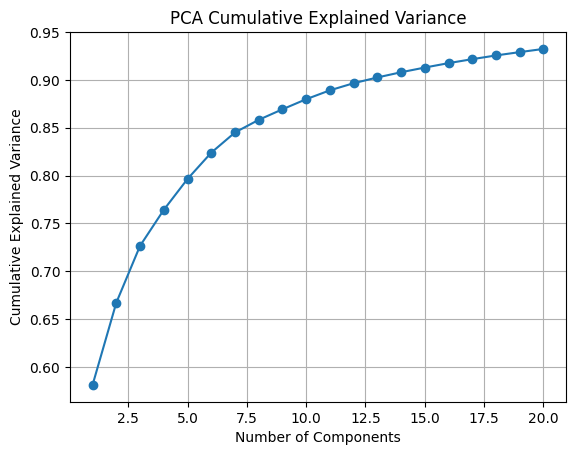

In [24]:
# 查看累计解释方差
plt.plot(range(1, 21), pca_ratio.explained_variance_ratio_.cumsum(), marker='o')
plt.title("PCA Cumulative Explained Variance")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.grid(True)
plt.show()


In [25]:
list_var_X = X_ratio.columns

# 生成载荷矩阵
loading = pd.DataFrame(
    pca_ratio.components_.T,
    index=list_var_X,
    columns=[f'PC{i+1}' for i in range(pca_ratio.n_components)]
)

# 查看每个主成分 loading 最大的变量
for pc in loading.columns[:10]:  # 可以修改为你关心的范围
    print(f"\nTop variables for {pc}:")
    print(loading[pc].abs().sort_values(ascending=False).head(10))


Top variables for PC1:
0745-0800_twt_entries    0.129881
0730-0745_twt_entries    0.127454
0745-0800_mon_entries    0.124738
0730-0745_mon_entries    0.124383
0800-0815_twt_entries    0.122569
0715-0730_twt_entries    0.118053
0715-0730_mon_entries    0.116798
0800-0815_mon_entries    0.115897
0815-0830_twt_entries    0.111143
0815-0830_mon_entries    0.104340
Name: PC1, dtype: float64

Top variables for PC2:
0815-0830_twt_exits    0.171476
0815-0830_mon_exits    0.171085
0800-0815_mon_exits    0.169286
0800-0815_twt_exits    0.167414
0830-0845_twt_exits    0.163324
0815-0830_fri_exits    0.161382
0830-0845_mon_exits    0.160992
0800-0815_fri_exits    0.158270
0830-0845_fri_exits    0.153252
0745-0800_mon_exits    0.141197
Name: PC2, dtype: float64

Top variables for PC3:
0845-0900_twt_entries    0.140133
0630-0645_fri_entries    0.139087
0645-0700_fri_entries    0.138886
0630-0645_twt_entries    0.138433
0645-0700_twt_entries    0.137658
0630-0645_mon_entries    0.137596
0615-0630_mo

In [26]:
# 设置主成分数量和每个主成分下要提取的变量数
top_n = 10
top_k = 15  # 提取 PC1–PC10

# 提取每个主成分中 loading 最大的变量名
top_vars_dict = {}
for pc in loading.columns[:top_k]:
    top_vars_dict[pc] = loading[pc].abs().sort_values(ascending=False).head(top_n).index.tolist()

# 转置为并列表格：每列是 PC1, PC2, ..., 每行是第 i 大变量名
top_vars_df = pd.DataFrame(top_vars_dict)

# 显示结果
from IPython.display import display
display(top_vars_df)

PC1                  PC2                    PC3  \
0  0745-0800_twt_entries  0815-0830_twt_exits  0845-0900_twt_entries   
1  0730-0745_twt_entries  0815-0830_mon_exits  0630-0645_fri_entries   
2  0745-0800_mon_entries  0800-0815_mon_exits  0645-0700_fri_entries   
3  0730-0745_mon_entries  0800-0815_twt_exits  0630-0645_twt_entries   
4  0800-0815_twt_entries  0830-0845_twt_exits  0645-0700_twt_entries   
5  0715-0730_twt_entries  0815-0830_fri_exits  0630-0645_mon_entries   
6  0715-0730_mon_entries  0830-0845_mon_exits  0615-0630_mon_entries   
7  0800-0815_mon_entries  0800-0815_fri_exits  0645-0700_mon_entries   
8  0815-0830_twt_entries  0830-0845_fri_exits  0615-0630_fri_entries   
9  0815-0830_mon_entries  0745-0800_mon_exits  0615-0630_twt_entries   

                     PC4                    PC5                  PC6  \
0  0745-0800_twt_entries  2200-2215_fri_entries  0915-0930_twt_exits   
1  0745-0800_mon_entries  2145-2200_mon_entries  0730-0745_twt_exits   
2  0800-0815_twt_entries  2145-2200_fri_entries  0715-0730_twt_exits   
3  0800-0815_mon_entries  2200-2215_mon_entries  0730-0745_mon_exits   
4  0730-0745_mon_entries  2130-2145_mon_entries  0930-0945_twt_exits   
5  0730-0745_twt_entries  2145-2200_twt_entries  0715-0730_mon_exits   
6  0815-0830_twt_entries  2130-2145_fri_entries  0900-0915_twt_exits   
7  0815-0830_mon_entries  2200-2215_twt_entries  0915-0930_mon_exits   
8  0715-0730_mon_entries  2115-2130_mon_entries  0730-0745_fri_exits   
9  0715-0730_twt_entries  2200-2215_sat_entries  0930-0945_mon_exits   

                     PC7                    PC8                    PC9  \
0  1530-1545_mon_entries  0730-0745_twt_entries  0730-0745_twt_entries   
1  1530-1545_twt_entries  0730-0745_mon_entries    0830-0845_twt_exits   
2  1545-1600_mon_entries  0745-0800_mon_entries  0745-0800_twt_entries   
3  1530-1545_fri_entries  0745-0800_twt_entries    1630-1645_sun_exits   
4  1545-1600_twt_entries  0715-0730_twt_entries    1700-1715_sun_exits   
5  1515-1530_mon_entries  0745-0800_fri_entries    0845-0900_twt_exits   
6  1515-1530_twt_entries  0715-0730_mon_entries  0715-0730_twt_entries   
7  1745-1800_mon_entries  0730-0745_fri_entries    1600-1615_sun_exits   
8  1800-1815_mon_entries  0845-0900_twt_entries  0730-0745_mon_entries   
9  1745-1800_twt_entries  0600-0615_mon_entries    1645-1700_sun_exits   

                    PC10                   PC11                   PC12  \
0  2300-2315_sat_entries  0845-0900_twt_entries  0730-0745_sat_entries   
1  2245-2300_sat_entries  0830-0845_twt_entries  0715-0730_sat_entries   
2  2315-2330_sat_entries    0830-0845_mon_exits  0745-0800_sat_entries   
3  2300-2315_fri_entries    0845-0900_mon_exits  0645-0700_sat_entries   
4  2230-2245_sat_entries  0900-0915_twt_entries  0700-0715_sat_entries   
5  2330-2345_sat_entries    0845-0900_twt_exits  0800-0815_sat_entries   
6  2315-2330_fri_entries  0845-0900_mon_entries  0815-0830_twt_entries   
7  2115-2130_mon_entries    0830-0845_twt_exits  1100-1115_sat_entries   
8  2245-2300_fri_entries    0915-0930_sun_exits  1130-1145_sat_entries   
9  2130-2145_mon_entries    0945-1000_sun_exits  1115-1130_sat_entries   

                    PC13                   PC14                   PC15  
0  1145-1200_sun_entries    1830-1845_twt_exits  1630-1645_mon_entries  
1  1200-1215_sun_entries  1700-1715_sat_entries  1645-1700_mon_entries  
2  1215-1230_sun_entries  1630-1645_sat_entries  1700-1715_mon_entries  
3  1800-1815_sun_entries  0745-0800_fri_entries  0715-0730_sun_entries  
4  1745-1800_sun_entries    1730-1745_sun_exits    1115-1130_sun_exits  
5  1815-1830_sun_entries    1545-1600_fri_exits    1245-1300_sun_exits  
6  1230-1245_sun_entries    1800-1815_twt_exits    1145-1200_sun_exits  
7    1745-1800_twt_exits    1545-1600_mon_exits  0800-0815_twt_entries  
8  1245-1300_sun_entries  1800-1815_twt_entries    1215-1230_sun_exits  
9  1830-1845_sun_entries    0845-0900_twt_exits  1715-1730_mon_entries

pc1

In [27]:
pc1_loading_ratio = pd.Series(pca_ratio.components_[0], index=X_ratio.columns)
df_plot = pc1_loading_ratio.reset_index()

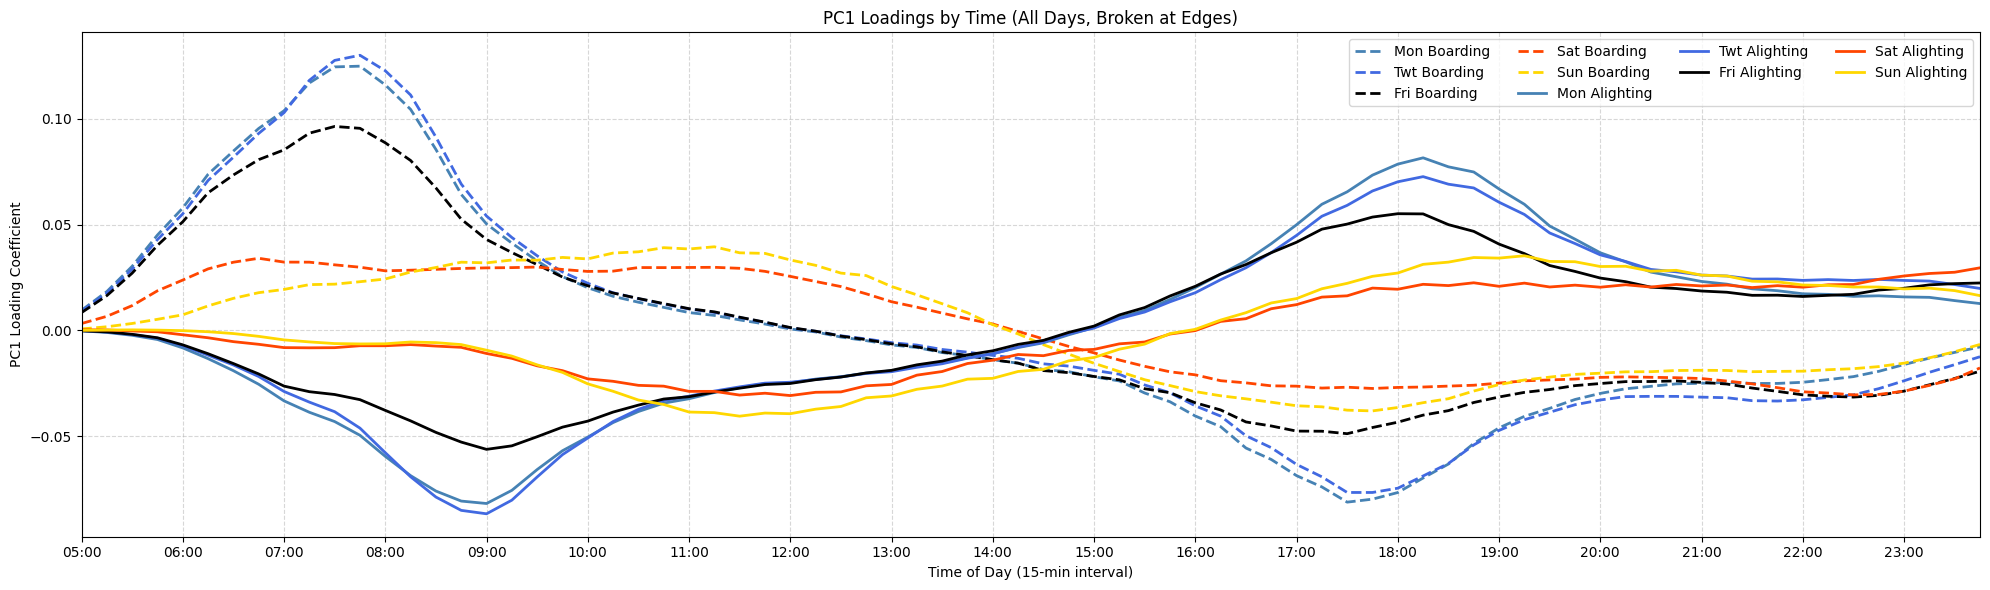

In [28]:
# Step 1: 准备绘图数据
df_plot = pc1_loading_ratio.reset_index()
df_plot.columns = ['Feature', 'Loading']
df_plot['Quarter'] = df_plot['Feature'].str.extract(r'^(\d{4}-\d{4})')[0]
df_plot['Day'] = df_plot['Feature'].str.extract(r'_(mon|twt|fri|sat|sun)_')[0].str.title()
df_plot['Type'] = df_plot['Feature'].str.extract(r'(entries|exits)')[0].map({'entries': 'Boarding', 'exits': 'Alighting'})

# 用 quarter_map 映射时间段 index
df_plot['TimeIndex'] = df_plot['Quarter'].map(quarter_map)
df_plot = df_plot.dropna(subset=['TimeIndex'])

# 设置颜色
day_colors = {
    'Mon': 'steelblue', 'Twt': 'royalblue', 'Fri': 'black', 'Sat': 'orangered', 'Sun': 'gold'
}

# Step 2: 绘图
plt.figure(figsize=(20, 6))

for typ in ['Boarding', 'Alighting']:
    for day, color in day_colors.items():
        subset = df_plot[(df_plot['Day'] == day) & (df_plot['Type'] == typ)].sort_values('TimeIndex')
        x = subset['TimeIndex'].values
        y = subset['Loading'].values

        # 插入 NaN 首尾断线
        if len(x) > 0:
            x = np.insert(x, [0, len(x)], [x[0]-1, x[-1]+1])
            y = np.insert(y, [0, len(y)], [np.nan, np.nan])
            plt.plot(x, y, label=f'{day} {typ}', color=color, linewidth=2, linestyle='-' if typ == 'Alighting' else '--')

# X轴 tick（只显示整点）
# quarter_map 是: {'0500-0515': 21, ...}
index_to_time = {v: k for k, v in quarter_map.items()}
xtick_locs = [
    i for i in sorted(index_to_time)
    if index_to_time[i][2:4] == '00' or index_to_time[i].endswith('0015')  # 例如 '2345-0000'
]
xtick_labels = []
for i in xtick_locs:
    time_str = index_to_time[i][:4]  # 如 '0500'
    hour = time_str[:2]
    minute = time_str[2:]
    label = f"{hour}:{minute}"
    xtick_labels.append(label)
plt.xticks(ticks=xtick_locs, labels=xtick_labels, rotation=0)
plt.xlabel("Time of Day (15-min interval)")
plt.ylabel("PC1 Loading Coefficient")
plt.title("PC1 Loadings by Time (All Days, Broken at Edges)")
plt.legend(ncol=4)
plt.grid(True, linestyle='--', alpha=0.5)
plt.xlim(21, 96)
plt.tight_layout()
plt.show()


In [46]:
# 获取 PC1 分数（即每个站点在 PC1 上的值）
pc1_scores = pca_ratio.transform(X_ratio)[:, 0]
# 如果 X_ratio 是以站点为索引的 DataFrame
pc1_scores_series = pd.Series(pc1_scores, index=X_ratio.index, name='PC1')
# 合并到 GeoDataFrame，确保 NLC 类型一致
stations = stations[['NLC', 'NAME', 'Zone', 'LINES', 'NETWORK', 'geometry']]
stations['NLC'] = stations['NLC'].astype(str)
pc1_scores_series.index = pc1_scores_series.index.astype(str)
stations_ratio = stations.merge(pc1_scores_series, left_on='NLC', right_index=True)

In [47]:
stations_ratio

NLC                         NAME Zone  \
0     500                   Acton Town    3   
1     501                     Barbican    1   
2     502                      Aldgate    1   
3     503                 Aldgate East    1   
4     504  Stratford International DLR  2,3   
..    ...                          ...  ...   
427  7467              Woodgrange Park  3,4   
428  7473                 Emerson Park    6   
468  9586               Imperial Wharf    2   
469  9587           Shepherd's Bush NR    2   
470  9846       Heathrow Terminal 5 EL    6   

                                        LINES             NETWORK  \
0                        District, Piccadilly  London Underground   
1    Circle, Hammersmith & City, Metropolitan  London Underground   
2                        Circle, Metropolitan  London Underground   
3                District, Hammersmith & City  London Underground   
4                                         DLR                None   
..                                        ...                 ...   
427                         London Overground                None   
428                         London Overground                None   
468                         London Overground                None   
469                         London Overground                None   
470                                  TfL Rail                None   

                  geometry       PC1  
0    POINT (519478 179592)  0.020844  
1    POINT (532004 181856) -0.205099  
2    POINT (533613 181262) -0.141972  
3    POINT (533936 181375) -0.110256  
4    POINT (538128 184761) -0.037388  
..                     ...       ...  
427  POINT (541821 185350)  0.065936  
428  POINT (553962 187871)  0.119085  
468  POINT (526291 176691) -0.171806  
469  POINT (523720 179920) -0.112083  
470  POINT (505109 175924) -0.087679  

[431 rows x 7 columns]

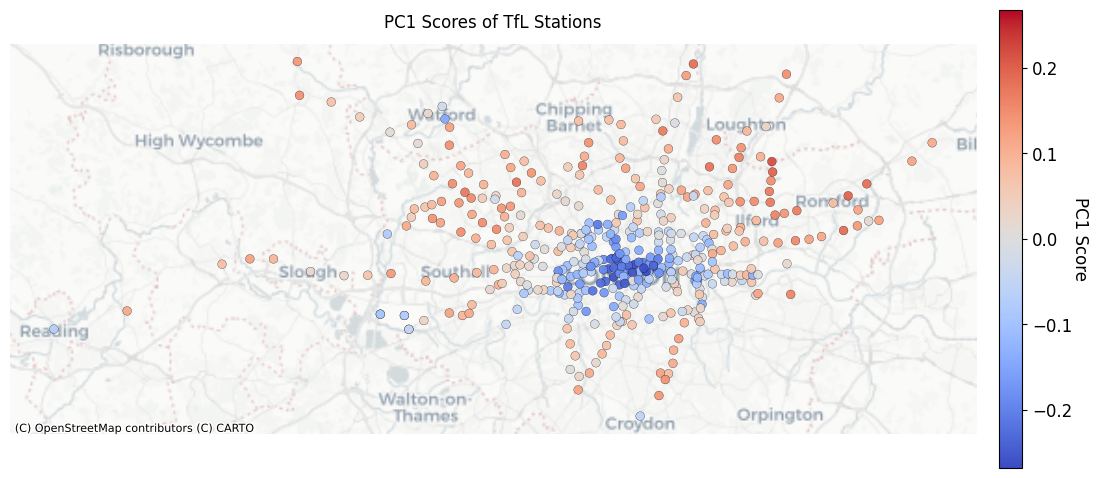

In [30]:
stations_pc1_webmerc = stations_ratio.to_crs(epsg=3857)
# 绘图
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 12
# 创建 figure & ax
fig, ax = plt.subplots(figsize=(12, 8))
# 获取绝对最大值以确保颜色对称（中点为0）
vmax = np.abs(stations_pc1_webmerc['PC1']).max()

# 绘制站点，颜色对称设置
stations_pc1_webmerc.plot(
    column='PC1',
    cmap='coolwarm',
    legend=False,
    ax=ax,
    markersize=40,
    alpha=0.95,
    vmin=-vmax, vmax=vmax,
    edgecolor='black',
    linewidth=0.2
)

# 添加灰色 OSM 底图
ctx.add_basemap(ax, 
    source=ctx.providers.CartoDB.Positron,  # 更清爽的灰底图
    crs=stations_pc1_webmerc.crs
)

# 去掉坐标轴
ax.set_axis_off()

# 添加标题
ax.set_title("PC1 Scores of TfL Stations", pad=12)

# 美化 legend（可选手动控制颜色条）
norm = mpl.colors.Normalize(vmin=-vmax, vmax=vmax)
sm = mpl.cm.ScalarMappable(cmap='coolwarm', norm=norm)
sm._A = []  # work around for matplotlib bug
cbar = fig.colorbar(sm, ax=ax, shrink=0.6, pad=0.02)
cbar.set_label('PC1 Score', rotation=270, labelpad=12)

plt.tight_layout()
plt.show()

PC2

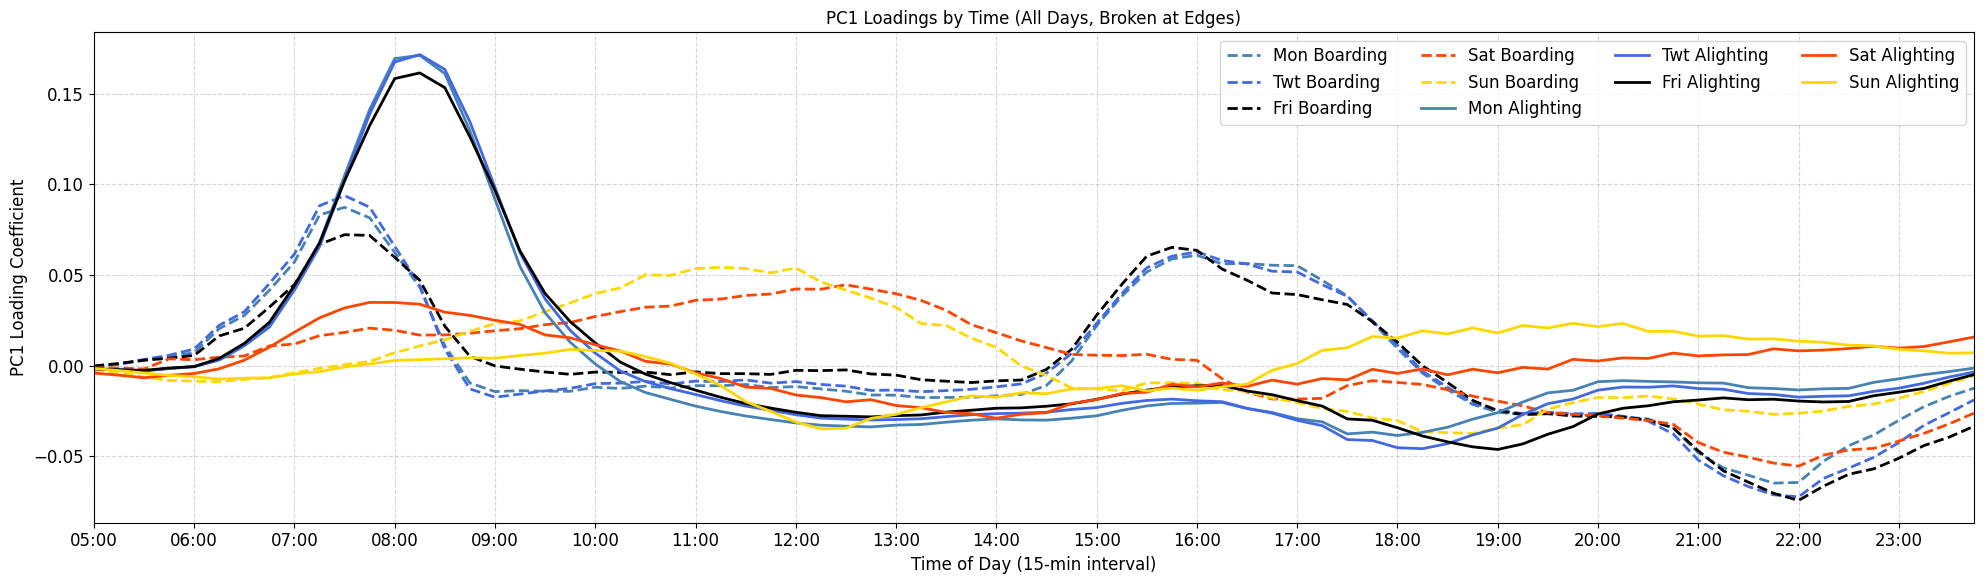

In [31]:
pc2_loading_ratio = pd.Series(pca_ratio.components_[1], index=X_ratio.columns)
df_plot = pc2_loading_ratio.reset_index()
df_plot = pc2_loading_ratio.reset_index()
df_plot.columns = ['Feature', 'Loading']
df_plot['Quarter'] = df_plot['Feature'].str.extract(r'^(\d{4}-\d{4})')[0]
df_plot['Day'] = df_plot['Feature'].str.extract(r'_(mon|twt|fri|sat|sun)_')[0].str.title()
df_plot['Type'] = df_plot['Feature'].str.extract(r'(entries|exits)')[0].map({'entries': 'Boarding', 'exits': 'Alighting'})

# 用 quarter_map 映射时间段 index
df_plot['TimeIndex'] = df_plot['Quarter'].map(quarter_map)
df_plot = df_plot.dropna(subset=['TimeIndex'])

# 设置颜色
day_colors = {
    'Mon': 'steelblue', 'Twt': 'royalblue', 'Fri': 'black', 'Sat': 'orangered', 'Sun': 'gold'
}

# Step 2: 绘图
plt.figure(figsize=(20, 6))

for typ in ['Boarding', 'Alighting']:
    for day, color in day_colors.items():
        subset = df_plot[(df_plot['Day'] == day) & (df_plot['Type'] == typ)].sort_values('TimeIndex')
        x = subset['TimeIndex'].values
        y = subset['Loading'].values

        # 插入 NaN 首尾断线
        if len(x) > 0:
            x = np.insert(x, [0, len(x)], [x[0]-1, x[-1]+1])
            y = np.insert(y, [0, len(y)], [np.nan, np.nan])
            plt.plot(x, y, label=f'{day} {typ}', color=color, linewidth=2, linestyle='-' if typ == 'Alighting' else '--')

# X轴 tick（只显示整点）
# quarter_map 是: {'0500-0515': 21, ...}
index_to_time = {v: k for k, v in quarter_map.items()}
xtick_locs = [
    i for i in sorted(index_to_time)
    if index_to_time[i][2:4] == '00' or index_to_time[i].endswith('0015')  # 例如 '2345-0000'
]
xtick_labels = []
for i in xtick_locs:
    time_str = index_to_time[i][:4]  # 如 '0500'
    hour = time_str[:2]
    minute = time_str[2:]
    label = f"{hour}:{minute}"
    xtick_labels.append(label)
plt.xticks(ticks=xtick_locs, labels=xtick_labels, rotation=0)
plt.xlabel("Time of Day (15-min interval)")
plt.ylabel("PC1 Loading Coefficient")
plt.title("PC1 Loadings by Time (All Days, Broken at Edges)")
plt.legend(ncol=4)
plt.grid(True, linestyle='--', alpha=0.5)
plt.xlim(21, 96)
plt.tight_layout()
plt.show()

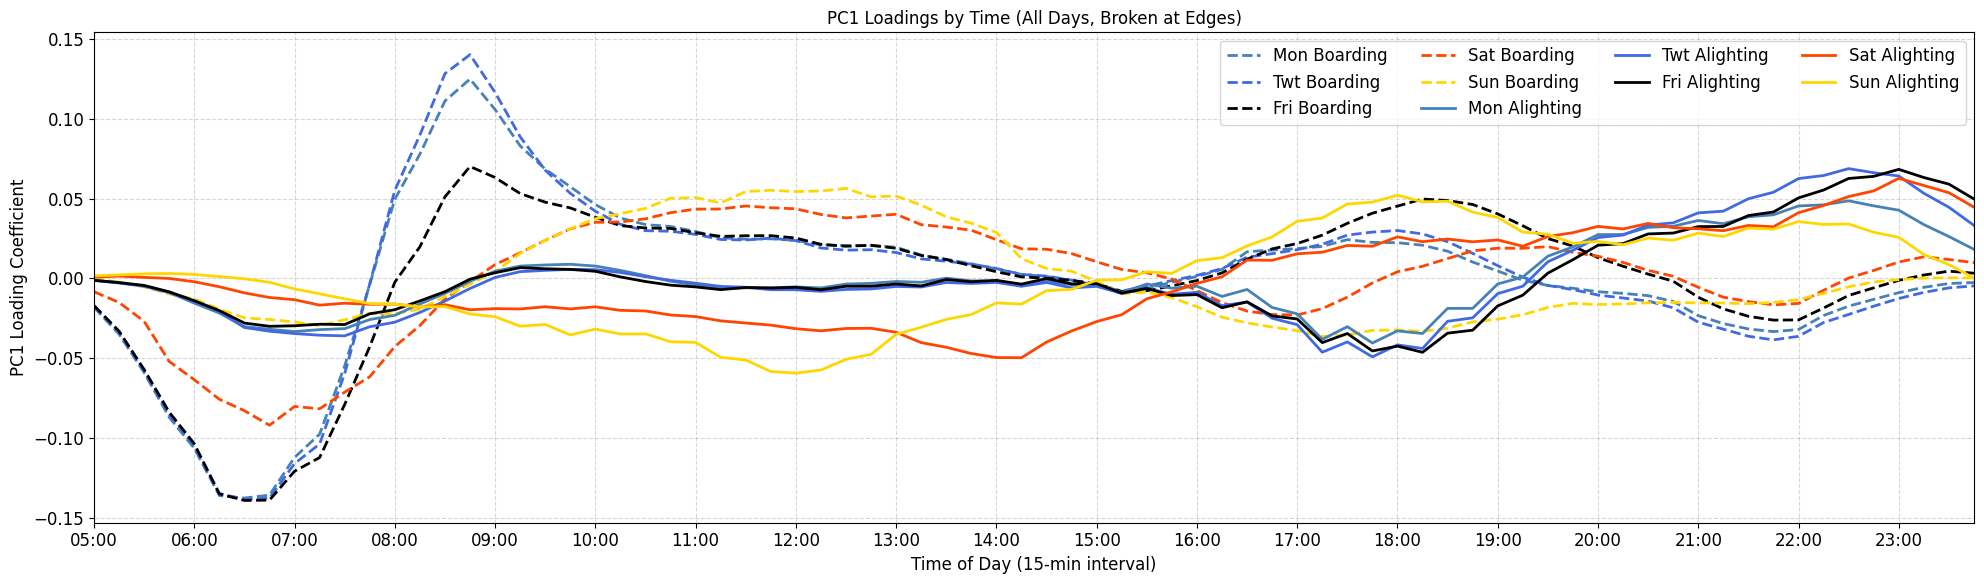

In [32]:
pc3_loading_ratio = pd.Series(pca_ratio.components_[2], index=X_ratio.columns)
df_plot = pc3_loading_ratio.reset_index()
df_plot = pc3_loading_ratio.reset_index()
df_plot.columns = ['Feature', 'Loading']
df_plot['Quarter'] = df_plot['Feature'].str.extract(r'^(\d{4}-\d{4})')[0]
df_plot['Day'] = df_plot['Feature'].str.extract(r'_(mon|twt|fri|sat|sun)_')[0].str.title()
df_plot['Type'] = df_plot['Feature'].str.extract(r'(entries|exits)')[0].map({'entries': 'Boarding', 'exits': 'Alighting'})

# 用 quarter_map 映射时间段 index
df_plot['TimeIndex'] = df_plot['Quarter'].map(quarter_map)
df_plot = df_plot.dropna(subset=['TimeIndex'])

# 设置颜色
day_colors = {
    'Mon': 'steelblue', 'Twt': 'royalblue', 'Fri': 'black', 'Sat': 'orangered', 'Sun': 'gold'
}

# Step 2: 绘图
plt.figure(figsize=(20, 6))

for typ in ['Boarding', 'Alighting']:
    for day, color in day_colors.items():
        subset = df_plot[(df_plot['Day'] == day) & (df_plot['Type'] == typ)].sort_values('TimeIndex')
        x = subset['TimeIndex'].values
        y = subset['Loading'].values

        # 插入 NaN 首尾断线
        if len(x) > 0:
            x = np.insert(x, [0, len(x)], [x[0]-1, x[-1]+1])
            y = np.insert(y, [0, len(y)], [np.nan, np.nan])
            plt.plot(x, y, label=f'{day} {typ}', color=color, linewidth=2, linestyle='-' if typ == 'Alighting' else '--')

# X轴 tick（只显示整点）
# quarter_map 是: {'0500-0515': 21, ...}
index_to_time = {v: k for k, v in quarter_map.items()}
xtick_locs = [
    i for i in sorted(index_to_time)
    if index_to_time[i][2:4] == '00' or index_to_time[i].endswith('0015')  # 例如 '2345-0000'
]
xtick_labels = []
for i in xtick_locs:
    time_str = index_to_time[i][:4]  # 如 '0500'
    hour = time_str[:2]
    minute = time_str[2:]
    label = f"{hour}:{minute}"
    xtick_labels.append(label)
plt.xticks(ticks=xtick_locs, labels=xtick_labels, rotation=0)
plt.xlabel("Time of Day (15-min interval)")
plt.ylabel("PC1 Loading Coefficient")
plt.title("PC1 Loadings by Time (All Days, Broken at Edges)")
plt.legend(ncol=4)
plt.grid(True, linestyle='--', alpha=0.5)
plt.xlim(21, 96)
plt.tight_layout()
plt.show()

In [48]:
X_cluster = X_pca_ratio[:, :10]

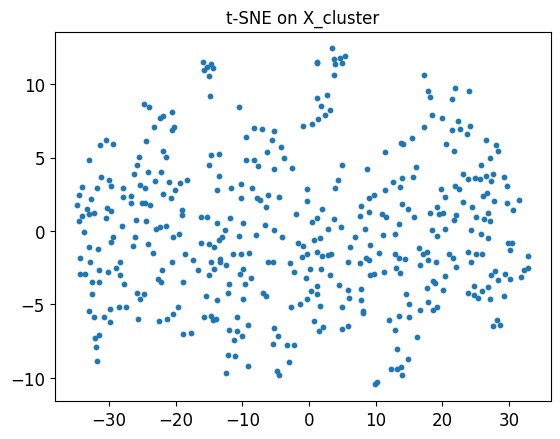

In [49]:
X_tsne = TSNE(n_components=2, random_state=42).fit_transform(X_cluster)

plt.scatter(X_tsne[:,0], X_tsne[:,1], s=10)
plt.title("t-SNE on X_cluster")
plt.show()

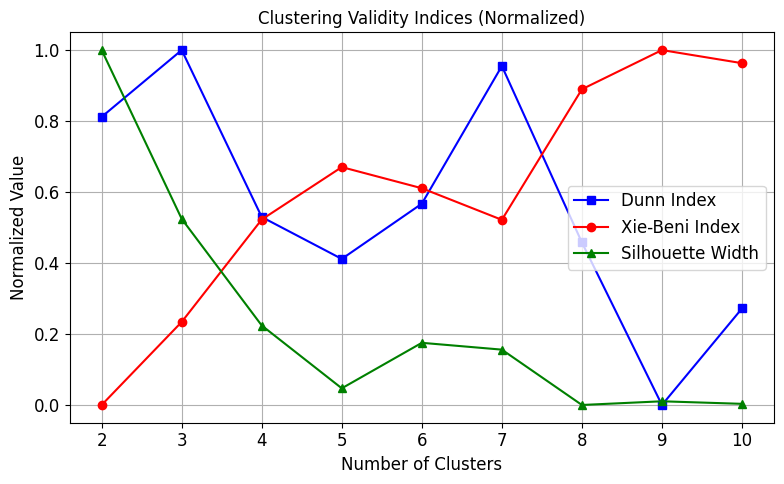

In [50]:
# Dunn Index 函数
def dunn_index(X, labels):
    unique_clusters = np.unique(labels)
    distances = cdist(X, X)
    max_intra = 0
    min_inter = np.inf
    
    for i in unique_clusters:
        intra_cluster = distances[np.ix_(labels == i, labels == i)]
        if len(intra_cluster) > 1:
            max_intra = max(max_intra, np.max(intra_cluster))

    for i in unique_clusters:
        for j in unique_clusters:
            if i < j:
                inter_cluster = distances[np.ix_(labels == i, labels == j)]
                min_inter = min(min_inter, np.min(inter_cluster))

    if max_intra == 0:
        return np.inf
    return min_inter / max_intra

# Xie-Beni Index 函数（已修正）
def xie_beni_index(X, labels, centroids):
    n_samples = X.shape[0]
    dist_sum = 0.0
    
    # 每个点到所属簇中心的距离平方
    for i in range(n_samples):
        center = centroids[labels[i]]
        dist_sum += np.linalg.norm(X[i] - center) ** 2

    # 最小簇中心距离平方
    min_centroid_dist = np.inf
    for i in range(len(centroids)):
        for j in range(i + 1, len(centroids)):
            dist = np.linalg.norm(centroids[i] - centroids[j]) ** 2
            if dist < min_centroid_dist:
                min_centroid_dist = dist

    if min_centroid_dist == 0:
        return np.inf

    return dist_sum / (n_samples * min_centroid_dist)

# 聚类有效性评估
K_range = range(2, 11)
dunn_scores = []
xb_scores = []
silhouette_scores = []

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_cluster)
    centroids = kmeans.cluster_centers_
    
    silhouette_scores.append(silhouette_score(X_cluster, labels))
    dunn_scores.append(dunn_index(X_cluster, labels))
    xb_scores.append(xie_beni_index(X_cluster, labels, centroids))

# 归一化
scaler = MinMaxScaler()
normalized_dunn = scaler.fit_transform(np.array(dunn_scores).reshape(-1, 1)).flatten()
normalized_xb = scaler.fit_transform(np.array(xb_scores).reshape(-1, 1)).flatten()
normalized_silhouette = scaler.fit_transform(np.array(silhouette_scores).reshape(-1, 1)).flatten()

# 绘图
plt.figure(figsize=(8, 5))
plt.plot(K_range, normalized_dunn, 's-', label="Dunn Index", color='blue')
plt.plot(K_range, normalized_xb, 'o-', label="Xie-Beni Index", color='red')
plt.plot(K_range, normalized_silhouette, '^-', label="Silhouette Width", color='green')

plt.xlabel("Number of Clusters")
plt.ylabel("Normalized Value")
plt.title("Clustering Validity Indices (Normalized)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [51]:
# 执行聚类
best_k = 6
kmeans = KMeans(n_clusters=best_k, random_state=42)
cluster_labels = kmeans.fit_predict(X_cluster)

In [52]:
cluster_counts = pd.Series(cluster_labels).value_counts().sort_index()
print(cluster_counts)

0     58
1    104
2     46
3    104
4    105
5     15
Name: count, dtype: int64


In [53]:
# 每组站点在 PC1 的均值（可扩展到 PC1-PC5）
for i in range(best_k):
    print(f"\nCluster {i} 平均主成分得分:")
    print(pd.DataFrame(X_pca_ratio[cluster_labels == i, :5]).mean())


Cluster 0 平均主成分得分:
0    0.006208
1    0.048591
2   -0.002376
3    0.000923
4    0.002956
dtype: float64

Cluster 1 平均主成分得分:
0    0.124746
1   -0.003018
2   -0.026760
3   -0.001883
4   -0.000904
dtype: float64

Cluster 2 平均主成分得分:
0   -0.194174
1    0.026232
2   -0.015598
3   -0.000023
4    0.002932
dtype: float64

Cluster 3 平均主成分得分:
0    0.053052
1   -0.011823
2    0.028958
3    0.003924
4    0.000927
dtype: float64

Cluster 4 平均主成分得分:
0   -0.069791
1   -0.009544
2    0.011865
3   -0.007881
4   -0.005027
dtype: float64

Cluster 5 平均主成分得分:
0   -0.172731
1   -0.098625
2   -0.041279
3    0.037516
4    0.014610
dtype: float64


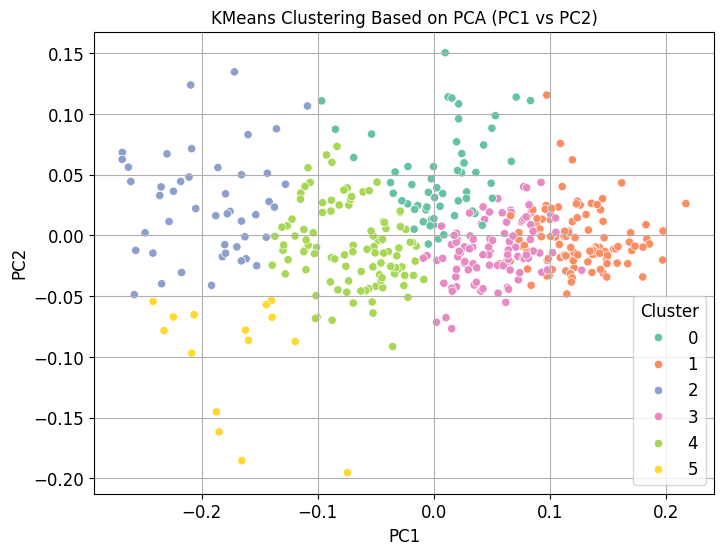

In [54]:
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca_ratio[:, 0], y=X_pca_ratio[:, 1], hue=cluster_labels, palette='Set2')
plt.title("KMeans Clustering Based on PCA (PC1 vs PC2)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.legend(title='Cluster')
plt.show()


In [55]:
ratio_result = pd.DataFrame({
    'NLC': X_ratio.index,
    'cluster_ratio': cluster_labels
})
print(ratio_result.head())

    NLC  cluster_ratio
0   750              0
1  1404              0
2  3000              3
3   500              0
4   502              2


In [56]:
from sklearn.metrics import silhouette_score
score = silhouette_score(X_cluster, cluster_labels)
print(f"Silhouette score: {score:.3f}")

Silhouette score: 0.209


In [57]:
stations_ratio['NLC'] = stations_ratio['NLC'].astype(str)
ratio_result['NLC'] = ratio_result['NLC'].astype(str)

# 合并：将聚类结果加到 GeoDataFrame 中
stations_ratio = stations_ratio.merge(ratio_result, on='NLC', how='left')
stations_ratio['cluster_ratio'] = stations_ratio['cluster_ratio'].fillna(-1).astype(int)

In [ ]:
stations_ratio.to_file("data/stations_ratio.geojson", driver="GeoJSON")

In [43]:
stations_exploded = stations_ratio.copy()

# 拆分 LINES 列，并展开为多行
stations_exploded['LINE'] = stations_exploded['LINES'].str.split(', ')
stations_exploded = stations_exploded.explode('LINE')


In [44]:
line_cluster_counts = (
    stations_exploded
    .groupby(['LINE', 'cluster_ratio'])
    .size()
    .unstack(fill_value=0)
    .sort_index()
)


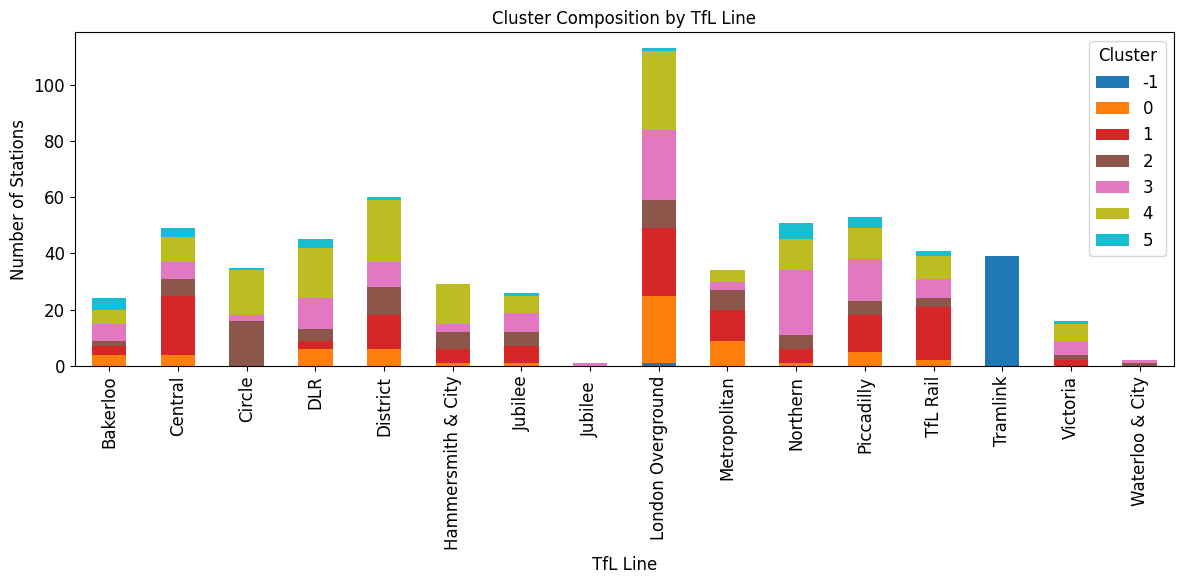

In [45]:
line_cluster_counts.plot(
    kind='bar',
    stacked=True,
    figsize=(12, 6),
    colormap='tab10'
)
plt.ylabel("Number of Stations")
plt.xlabel("TfL Line")
plt.title("Cluster Composition by TfL Line")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()


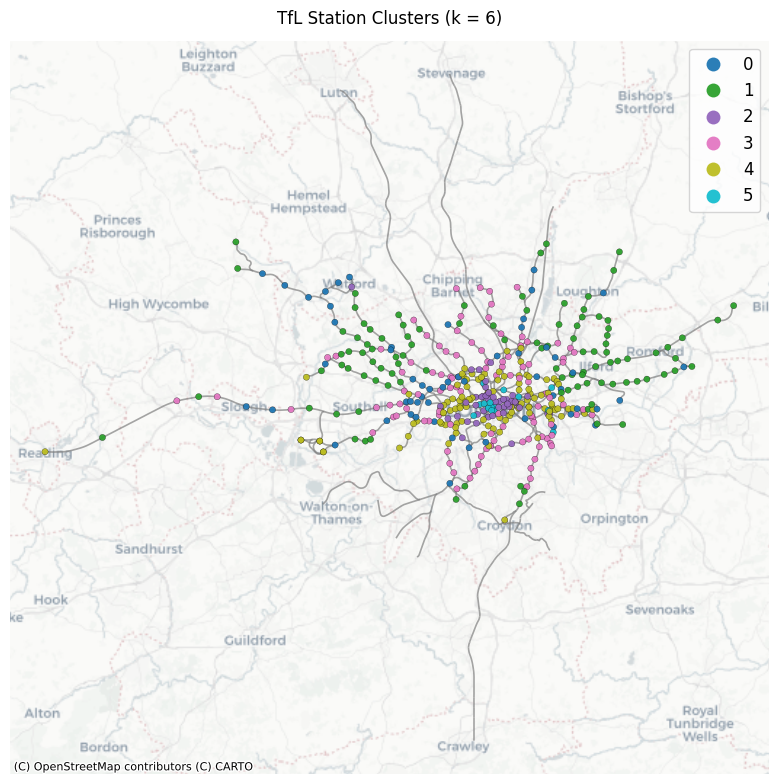

In [60]:
# 投影到 Web Mercator（如果还没做）
stations_cluster_webmerc = stations_ratio.to_crs(epsg=3857)
lines_webmerc = lines.to_crs(epsg=3857)

# 设置绘图参数
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 12

# 创建 figure & ax
fig, ax = plt.subplots(figsize=(12, 8))

# 使用分类配色（tab10 支持最多10类）
lines_webmerc.plot(
    ax=ax,
    linewidth=1.2,
    color='gray',
    alpha=0.7,
    zorder=1  # 确保在站点图层下方
)

stations_cluster_webmerc.plot(
    column='cluster_ratio',
    cmap='tab10',  # 分类色彩
    categorical=True,
    legend=True,
    ax=ax,
    markersize=20,
    alpha=0.95,
    edgecolor='black',
    linewidth=0.2
)


# 添加灰色 OSM 底图
ctx.add_basemap(ax, 
    source=ctx.providers.CartoDB.Positron,
    crs=stations_cluster_webmerc.crs
)

# 去掉坐标轴
ax.set_axis_off()

# 添加标题
ax.set_title("TfL Station Clusters (k = 6)", pad=12)

plt.tight_layout()
plt.show()

In [61]:
# 确保 NLC 都是字符串格式
analyse_df['NLC'] = analyse_df['NLC'].astype(str)
ratio_result['NLC'] = ratio_result['NLC'].astype(str)


# 合并到原始分析表中
analyse_ratio = analyse_df.merge(ratio_result, on='NLC', how='left')

# 可选：填补未聚类的站点
analyse_ratio['cluster_ratio'] = analyse_ratio['cluster_ratio'].fillna(-1).astype(int)


In [62]:
def extract_hour(colname):
    # 提取起始小时，比如 "0600-0615_fri_entries" → 6
    return int(colname[:2])

In [63]:
entry_curves = (
    analyse_ratio
    .groupby('cluster_ratio')[entry_cols]
    .mean()
)

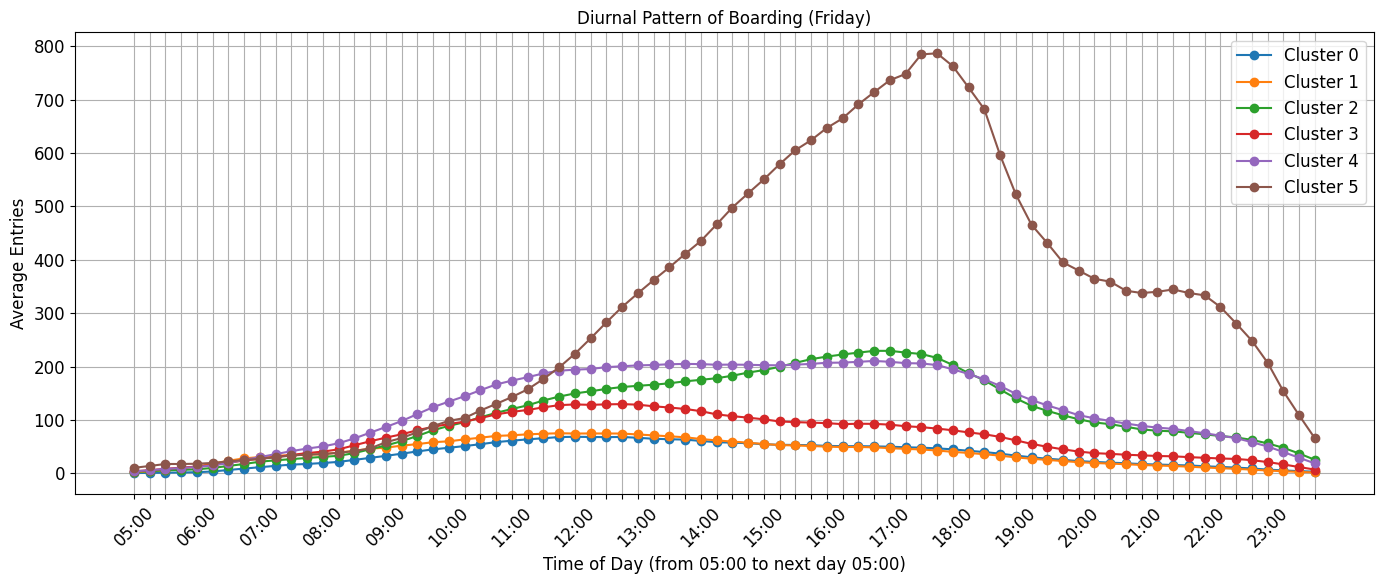

In [64]:
entry_cols = [col for col in analyse_ratio.columns if 'entries' in col and 'fri' in col]
sorted_cols = sorted(
    entry_curves.columns,
    key=lambda x: quarter_map.get(x.replace('_fri_entries', ''), 999)
)
entry_curves = entry_curves[sorted_cols]

# 开始绘图
plt.figure(figsize=(14, 6))
for cluster_id, row in entry_curves.iterrows():
    plt.plot(entry_curves.columns, row.values, label=f'Cluster {cluster_id}', marker='o')

# 设置 xticks（每小时显示一个 label）
xticks = entry_curves.columns
xticklabels = []

for col in xticks:
    time_str = col.split('_')[0]      # "0615-0630"
    hour = int(time_str[:2])
    minute = int(time_str[2:4])
    if minute == 0:  # 每小时整点显示
        xticklabels.append(f"{hour:02d}:00")
    else:
        xticklabels.append("")

plt.xticks(ticks=xticks, labels=xticklabels, rotation=45)

plt.xlabel("Time of Day (from 05:00 to next day 05:00)")
plt.ylabel("Average Entries")
plt.title("Diurnal Pattern of Boarding (Friday)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

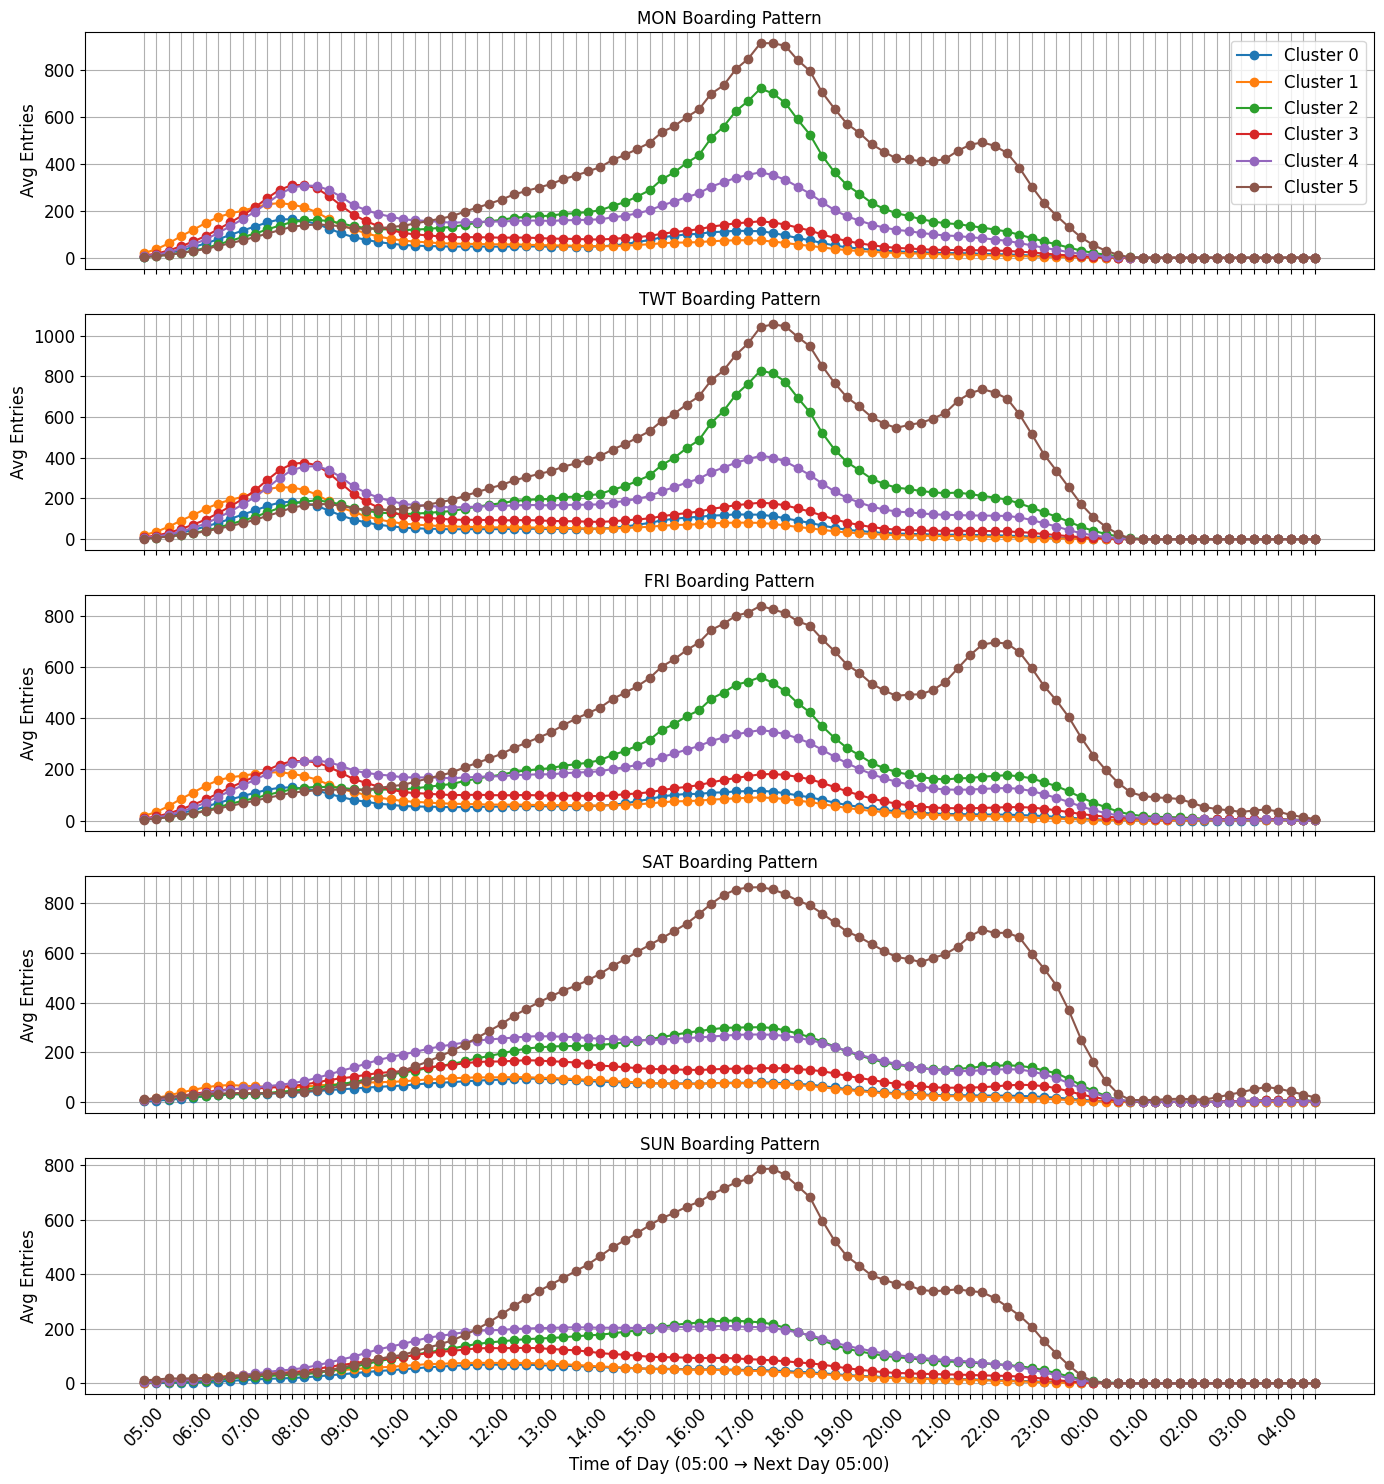

In [65]:
import matplotlib.pyplot as plt

days = ['mon', 'twt', 'fri', 'sat', 'sun']
n_days = len(days)

fig, axes = plt.subplots(n_days, 1, figsize=(14, 3 * n_days), sharex=True)

for i, day in enumerate(days):
    # 提取该天的 entries 列
    entry_cols = [col for col in analyse_ratio.columns if f'entries' in col and f'{day}' in col]

    # 构建曲线
    entry_curves = (
        analyse_ratio
        .groupby('cluster_ratio')[entry_cols]
        .mean()
    )

    # 按 quarter_map 顺序排序
    sorted_cols = sorted(entry_curves.columns, key=lambda x: quarter_map.get(x.replace(f'_{day}_entries', ''), 999))
    entry_curves = entry_curves[sorted_cols]

    # 绘图：x 坐标用 0~95，y 为对应值
    ax = axes[i]
    x = list(range(len(entry_curves.columns)))  # [0, 1, ..., 95]
    for cluster_id, row in entry_curves.iterrows():
        ax.plot(x, row.values, label=f'Cluster {cluster_id}', marker='o')

    # 设置 xtick 每小时显示一次
    xticks = list(range(len(entry_curves.columns)))  # x 是 0 到 95
    xticklabels = []
    for col in entry_curves.columns:
        time_str = col.split('_')[0]  # "0615-0630"
        hour = int(time_str[:2])
        minute = int(time_str[2:4])
        if minute == 0:
            xticklabels.append(f"{hour:02d}:00")
        else:
            xticklabels.append("")

    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels, rotation=45)

    ax.set_title(f"{day.upper()} Boarding Pattern")
    ax.set_ylabel("Avg Entries")
    ax.grid(True)
    if i == n_days - 1:
        ax.set_xlabel("Time of Day (05:00 → Next Day 05:00)")
    if i == 0:
        ax.legend(loc='upper right')

plt.tight_layout()
plt.show()


第二种方法 Rho

In [66]:
pca_rho = PCA(n_components=30)
X_pca_rho = pca_rho.fit_transform(X_rho)

In [67]:
# 每个主成分的解释比例和累计比例
explained_var = pd.DataFrame({
    'Principal Component': [f'PC{i+1}' for i in range(len(pca_rho.explained_variance_ratio_))],
    'Explained Variance Ratio': pca_rho.explained_variance_ratio_,
    'Cumulative Explained Variance': pca_rho.explained_variance_ratio_.cumsum()
})

print(explained_var.head(10))  # 显示前10个主成分的解释能力

  Principal Component  Explained Variance Ratio  Cumulative Explained Variance
0                 PC1                  0.503768                       0.503768
1                 PC2                  0.074304                       0.578072
2                 PC3                  0.065717                       0.643789
3                 PC4                  0.054932                       0.698722
4                 PC5                  0.045632                       0.744354
5                 PC6                  0.029385                       0.773739
6                 PC7                  0.017103                       0.790842
7                 PC8                  0.016573                       0.807415
8                 PC9                  0.013682                       0.821097
9                PC10                  0.010464                       0.831561


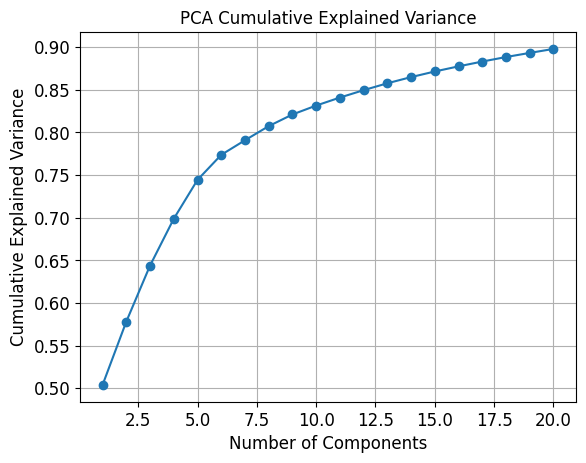

In [68]:
# 查看累计解释方差
plt.plot(
    range(1, 21),
    pca_rho.explained_variance_ratio_.cumsum()[:20],  # 只取前 20 项
    marker='o'
)
plt.title("PCA Cumulative Explained Variance")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.grid(True)
plt.show()

In [69]:
list_var_X = X_rho.columns

# 生成载荷矩阵
loading = pd.DataFrame(
    pca_rho.components_.T,
    index=list_var_X,
    columns=[f'PC{i+1}' for i in range(pca_rho.n_components)]
)

# 查看每个主成分 loading 最大的变量
for pc in loading.columns[:10]:  # 可以修改为你关心的范围
    print(f"\nTop variables for {pc}:")
    print(loading[pc].abs().sort_values(ascending=False).head(10))


Top variables for PC1:
0700-0715_twt_entries    0.068544
0700-0715_mon_entries    0.066889
0645-0700_mon_entries    0.064651
0800-0815_twt_entries    0.064286
1800-1815_mon_exits      0.064214
0645-0700_twt_entries    0.063513
1900-1915_twt_entries    0.063435
1745-1800_mon_exits      0.061801
1730-1745_mon_exits      0.061501
1845-1900_twt_entries    0.061337
Name: PC1, dtype: float64

Top variables for PC2:
0800-0815_fri_exits    0.112429
0815-0830_twt_exits    0.106766
0815-0830_fri_exits    0.106106
0830-0845_fri_exits    0.104132
0800-0815_twt_exits    0.102134
0800-0815_mon_exits    0.100093
0815-0830_mon_exits    0.098734
0845-0900_fri_exits    0.095232
0745-0800_fri_exits    0.094781
0745-0800_mon_exits    0.094471
Name: PC2, dtype: float64

Top variables for PC3:
0615-0630_fri_entries    0.092921
0630-0645_fri_entries    0.087918
0700-0715_sun_entries    0.086452
0600-0615_fri_entries    0.086417
0545-0600_mon_entries    0.086258
0500-0515_fri_entries    0.086041
0600-0615_mo

In [70]:
# 设置主成分数量和每个主成分下要提取的变量数
top_n = 10
top_k = 15  # 提取 PC1–PC10

# 提取每个主成分中 loading 最大的变量名
top_vars_dict = {}
for pc in loading.columns[:top_k]:
    top_vars_dict[pc] = loading[pc].abs().sort_values(ascending=False).head(top_n).index.tolist()

# 转置为并列表格：每列是 PC1, PC2, ..., 每行是第 i 大变量名
top_vars_df = pd.DataFrame(top_vars_dict)

# 显示结果
from IPython.display import display
display(top_vars_df)

PC1                  PC2                    PC3  \
0  0700-0715_twt_entries  0800-0815_fri_exits  0615-0630_fri_entries   
1  0700-0715_mon_entries  0815-0830_twt_exits  0630-0645_fri_entries   
2  0645-0700_mon_entries  0815-0830_fri_exits  0700-0715_sun_entries   
3  0800-0815_twt_entries  0830-0845_fri_exits  0600-0615_fri_entries   
4    1800-1815_mon_exits  0800-0815_twt_exits  0545-0600_mon_entries   
5  0645-0700_twt_entries  0800-0815_mon_exits  0500-0515_fri_entries   
6  1900-1915_twt_entries  0815-0830_mon_exits  0600-0615_mon_entries   
7    1745-1800_mon_exits  0845-0900_fri_exits  0530-0545_fri_entries   
8    1730-1745_mon_exits  0745-0800_fri_exits  0630-0645_sat_entries   
9  1845-1900_twt_entries  0745-0800_mon_exits  0500-0515_mon_entries   

                     PC4                    PC5                    PC6  \
0  0700-0715_sun_entries  2345-0000_sat_entries    0700-0715_twt_exits   
1  0730-0745_sun_entries  2330-2345_sat_entries    0645-0700_fri_exits   
2  0715-0730_sun_entries  0545-0600_sun_entries    0645-0700_twt_exits   
3    0700-0715_sat_exits  0600-0615_sun_entries  0630-0645_sun_entries   
4  0645-0700_sun_entries  0700-0715_sun_entries  0700-0715_sun_entries   
5  0745-0800_sun_entries  0530-0545_sun_entries  0615-0630_sun_entries   
6    0830-0845_sun_exits  2315-2330_sat_entries    0700-0715_mon_exits   
7  1200-1215_twt_entries    0630-0645_sun_exits  0645-0700_sun_entries   
8    0645-0700_sat_exits  2000-2015_fri_entries    0615-0630_fri_exits   
9  1215-1230_twt_entries  1915-1930_fri_entries    0630-0645_twt_exits   

                     PC7                    PC8                    PC9  \
0  1530-1545_mon_entries  0600-0615_sun_entries  1400-1415_sun_entries   
1  1515-1530_mon_entries  0545-0600_sun_entries    1530-1545_sun_exits   
2  1530-1545_twt_entries  0615-0630_sun_entries    1515-1530_sun_exits   
3  1530-1545_fri_entries  0530-0545_sun_entries    1530-1545_sat_exits   
4  1515-1530_twt_entries  0630-0645_sun_entries  1330-1345_sun_entries   
5  1545-1600_twt_entries    1930-1945_sun_exits    0945-1000_sat_exits   
6  1500-1515_mon_entries    2000-2015_sun_exits    1600-1615_sat_exits   
7  1545-1600_mon_entries  0515-0530_sun_entries    1545-1600_sat_exits   
8  1545-1600_fri_entries    1945-2000_sat_exits    1700-1715_sat_exits   
9  1515-1530_fri_entries    0630-0645_sun_exits    1515-1530_sat_exits   

                    PC10                   PC11                   PC12  \
0  2345-0000_sun_entries  1045-1100_twt_entries    0600-0615_sun_exits   
1    0815-0830_twt_exits  0545-0600_sun_entries  0600-0615_sun_entries   
2  2330-2345_sun_entries  0600-0615_sun_entries    0615-0630_sun_exits   
3    0815-0830_mon_exits  1800-1815_sat_entries  0530-0545_sun_entries   
4    0800-0815_twt_exits  1045-1100_mon_entries  0545-0600_sun_entries   
5    0800-0815_mon_exits    2345-0000_sat_exits    0630-0645_sun_exits   
6    2345-0000_sun_exits  1115-1130_mon_entries    0530-0545_sun_exits   
7  2315-2330_sun_entries  1045-1100_fri_entries    0545-0600_sun_exits   
8    1600-1615_twt_exits    2345-0000_fri_exits  0515-0530_sun_entries   
9    0645-0700_fri_exits    0545-0600_twt_exits    0515-0530_sun_exits   

                    PC13                   PC14                   PC15  
0    0800-0815_sat_exits  0730-0745_sun_entries  0530-0545_sun_entries  
1    0815-0830_sat_exits  0830-0845_sun_entries    1615-1630_twt_exits  
2    0830-0845_sat_exits  0845-0900_sun_entries    0600-0615_sun_exits  
3    0745-0800_sat_exits  0745-0800_sun_entries    1945-2000_sat_exits  
4    0845-0900_sat_exits  0800-0815_sun_entries    2300-2315_sun_exits  
5    0730-0745_sat_exits    2315-2330_sun_exits  0515-0530_sun_entries  
6    0900-0915_sat_exits  0900-0915_sun_entries    0615-0630_sun_exits  
7  1915-1930_sat_entries  0500-0515_twt_entries    1615-1630_mon_exits  
8  1945-2000_sat_entries  0815-0830_sun_entries    1000-1015_sat_exits  
9    0715-0730_sat_exits    2030-2045_sat_exits    16

In [71]:
pc1_loading_rho = pd.Series(pca_rho.components_[0], index=X_rho.columns)
df_plot = pc1_loading_rho.reset_index()

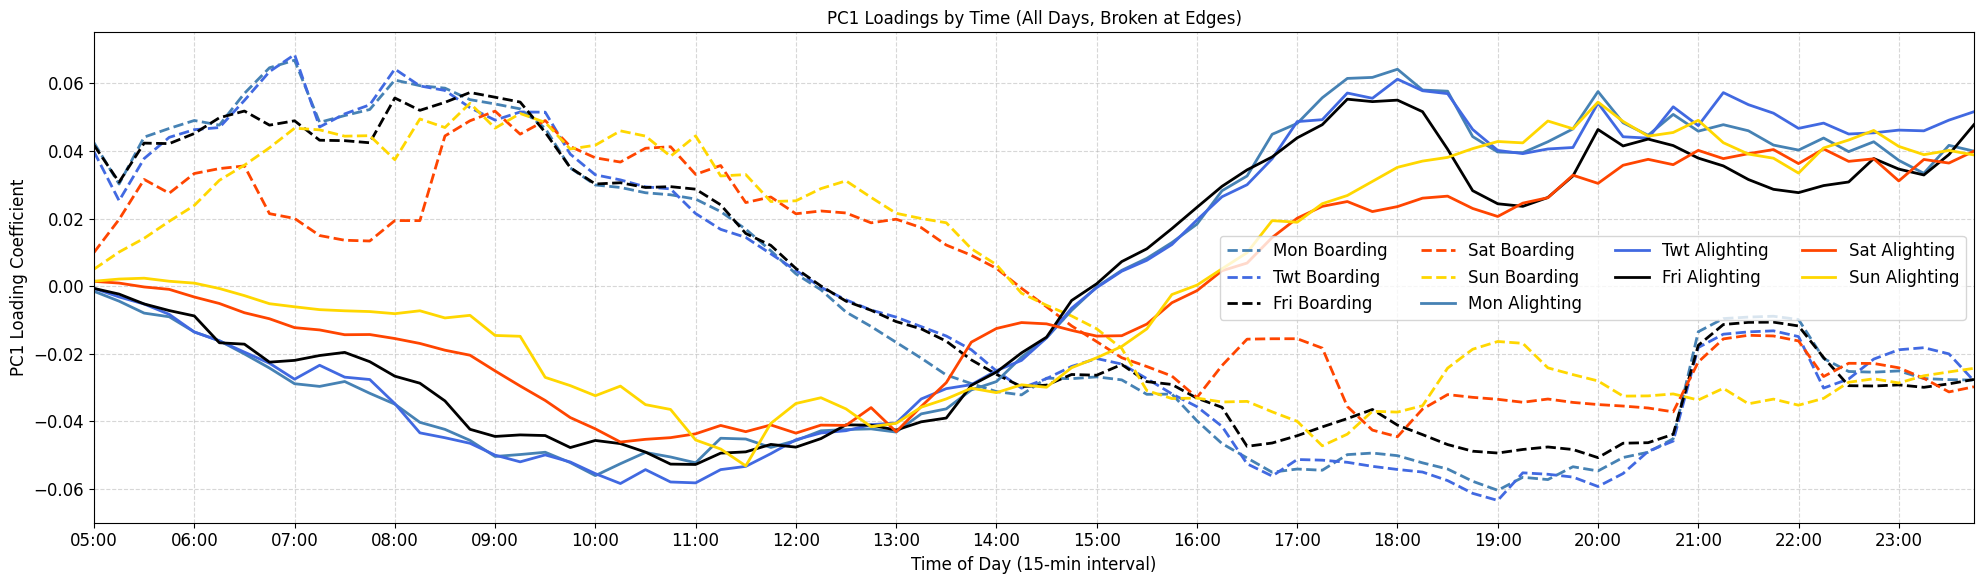

In [72]:
# Step 1: 准备绘图数据
df_plot = pc1_loading_rho.reset_index()
df_plot.columns = ['Feature', 'Loading']
df_plot['Quarter'] = df_plot['Feature'].str.extract(r'^(\d{4}-\d{4})')[0]
df_plot['Day'] = df_plot['Feature'].str.extract(r'_(mon|twt|fri|sat|sun)_')[0].str.title()
df_plot['Type'] = df_plot['Feature'].str.extract(r'(entries|exits)')[0].map({'entries': 'Boarding', 'exits': 'Alighting'})

# 用 quarter_map 映射时间段 index
df_plot['TimeIndex'] = df_plot['Quarter'].map(quarter_map)
df_plot = df_plot.dropna(subset=['TimeIndex'])

# 设置颜色
day_colors = {
    'Mon': 'steelblue', 'Twt': 'royalblue', 'Fri': 'black', 'Sat': 'orangered', 'Sun': 'gold'
}

# Step 2: 绘图
plt.figure(figsize=(20, 6))

for typ in ['Boarding', 'Alighting']:
    for day, color in day_colors.items():
        subset = df_plot[(df_plot['Day'] == day) & (df_plot['Type'] == typ)].sort_values('TimeIndex')
        x = subset['TimeIndex'].values
        y = subset['Loading'].values

        # 插入 NaN 首尾断线
        if len(x) > 0:
            x = np.insert(x, [0, len(x)], [x[0]-1, x[-1]+1])
            y = np.insert(y, [0, len(y)], [np.nan, np.nan])
            plt.plot(x, y, label=f'{day} {typ}', color=color, linewidth=2, linestyle='-' if typ == 'Alighting' else '--')

# X轴 tick（只显示整点）
# quarter_map 是: {'0500-0515': 21, ...}
index_to_time = {v: k for k, v in quarter_map.items()}
xtick_locs = [
    i for i in sorted(index_to_time)
    if index_to_time[i][2:4] == '00' or index_to_time[i].endswith('0015')  # 例如 '2345-0000'
]
xtick_labels = []
for i in xtick_locs:
    time_str = index_to_time[i][:4]  # 如 '0500'
    hour = time_str[:2]
    minute = time_str[2:]
    label = f"{hour}:{minute}"
    xtick_labels.append(label)
plt.xticks(ticks=xtick_locs, labels=xtick_labels, rotation=0)
plt.xlabel("Time of Day (15-min interval)")
plt.ylabel("PC1 Loading Coefficient")
plt.title("PC1 Loadings by Time (All Days, Broken at Edges)")
plt.legend(ncol=4)
plt.grid(True, linestyle='--', alpha=0.5)
plt.xlim(21, 96)
plt.tight_layout()
plt.show()

In [73]:
# 获取 PC1 分数（即每个站点在 PC1 上的值）
pc1_rcho = pca_rho.transform(X_rho)[:, 0]
pc1_rcho_series = pd.Series(pc1_rcho , index=X_rho.index, name='PC1')
stations['NLC'] = stations['NLC'].astype(str)
pc1_rcho_series.index = pc1_rcho_series.index.astype(str)
stations_rho = stations.merge(pc1_rcho_series, left_on='NLC', right_index=True)

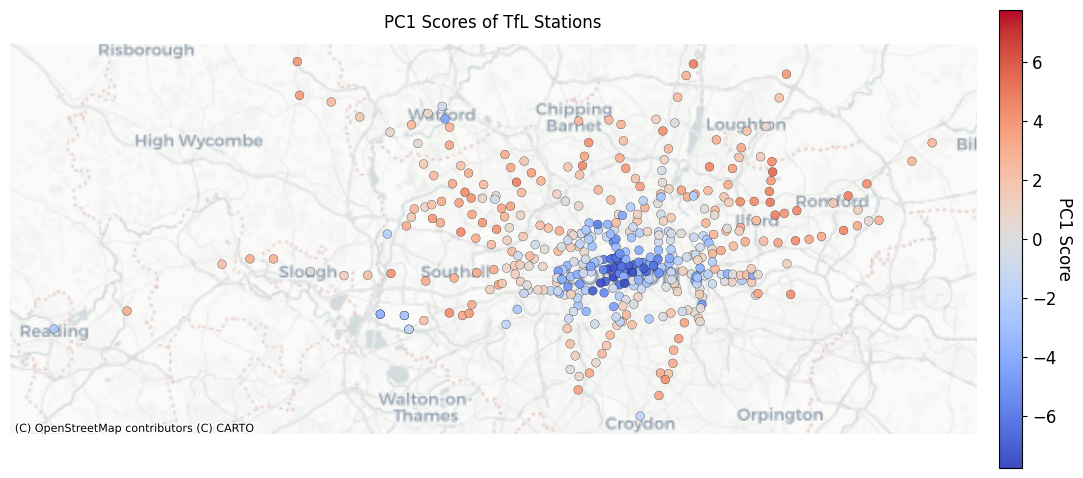

In [74]:
stations_rho_webmerc = stations_rho.to_crs(epsg=3857)
# 绘图
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 12
# 创建 figure & ax
fig, ax = plt.subplots(figsize=(12, 8))
# 获取绝对最大值以确保颜色对称（中点为0）
vmax = np.abs(stations_rho_webmerc['PC1']).max()

# 绘制站点，颜色对称设置
stations_rho_webmerc.plot(
    column='PC1',
    cmap='coolwarm',
    legend=False,
    ax=ax,
    markersize=40,
    alpha=0.95,
    vmin=-vmax, vmax=vmax,
    edgecolor='black',
    linewidth=0.2
)

# 添加灰色 OSM 底图
ctx.add_basemap(ax, 
    source=ctx.providers.CartoDB.Positron,  # 更清爽的灰底图
    crs=stations_rho_webmerc.crs
)

# 去掉坐标轴
ax.set_axis_off()

# 添加标题
ax.set_title("PC1 Scores of TfL Stations", pad=12)

# 美化 legend（可选手动控制颜色条）
norm = mpl.colors.Normalize(vmin=-vmax, vmax=vmax)
sm = mpl.cm.ScalarMappable(cmap='coolwarm', norm=norm)
sm._A = []  # work around for matplotlib bug
cbar = fig.colorbar(sm, ax=ax, shrink=0.6, pad=0.02)
cbar.set_label('PC1 Score', rotation=270, labelpad=12)

plt.tight_layout()
plt.show()

In [75]:
X_cluster_0 = X_pca_rho[:, :10]

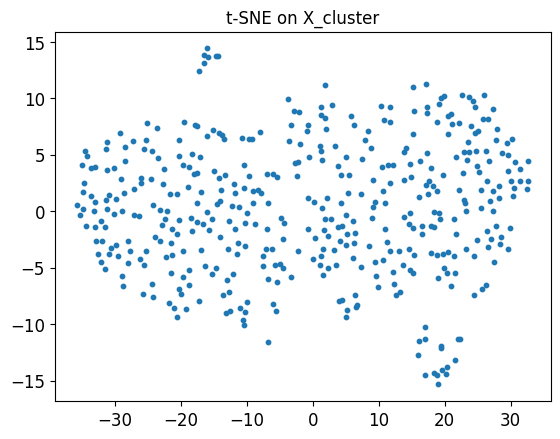

In [76]:
X_tsne = TSNE(n_components=2, random_state=42).fit_transform(X_cluster_0)

plt.scatter(X_tsne[:,0], X_tsne[:,1], s=10)
plt.title("t-SNE on X_cluster")
plt.show()

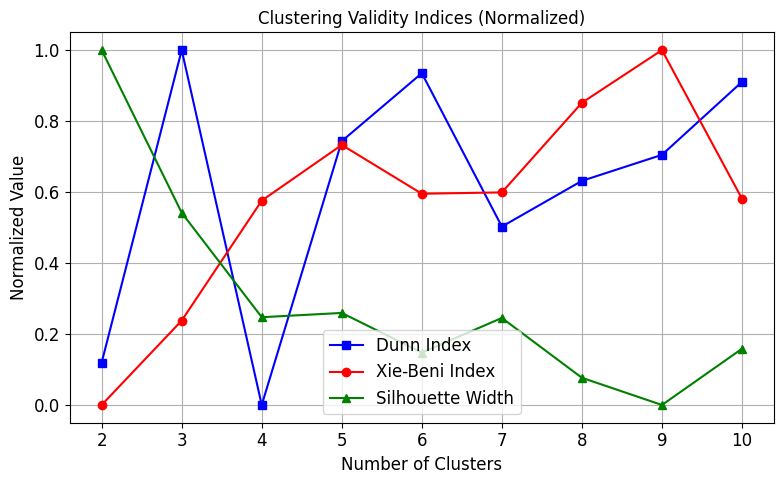

In [77]:
# Dunn Index 函数
def dunn_index(X, labels):
    unique_clusters = np.unique(labels)
    distances = cdist(X, X)
    max_intra = 0
    min_inter = np.inf
    
    for i in unique_clusters:
        intra_cluster = distances[np.ix_(labels == i, labels == i)]
        if len(intra_cluster) > 1:
            max_intra = max(max_intra, np.max(intra_cluster))

    for i in unique_clusters:
        for j in unique_clusters:
            if i < j:
                inter_cluster = distances[np.ix_(labels == i, labels == j)]
                min_inter = min(min_inter, np.min(inter_cluster))

    if max_intra == 0:
        return np.inf
    return min_inter / max_intra

# Xie-Beni Index 函数（已修正）
def xie_beni_index(X, labels, centroids):
    n_samples = X.shape[0]
    dist_sum = 0.0
    
    # 每个点到所属簇中心的距离平方
    for i in range(n_samples):
        center = centroids[labels[i]]
        dist_sum += np.linalg.norm(X[i] - center) ** 2

    # 最小簇中心距离平方
    min_centroid_dist = np.inf
    for i in range(len(centroids)):
        for j in range(i + 1, len(centroids)):
            dist = np.linalg.norm(centroids[i] - centroids[j]) ** 2
            if dist < min_centroid_dist:
                min_centroid_dist = dist

    if min_centroid_dist == 0:
        return np.inf

    return dist_sum / (n_samples * min_centroid_dist)

# 聚类有效性评估
K_range = range(2, 11)
dunn_scores = []
xb_scores = []
silhouette_scores = []

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_cluster_0)
    centroids = kmeans.cluster_centers_
    
    silhouette_scores.append(silhouette_score(X_cluster_0, labels))
    dunn_scores.append(dunn_index(X_cluster_0, labels))
    xb_scores.append(xie_beni_index(X_cluster_0, labels, centroids))

# 归一化
scaler = MinMaxScaler()
normalized_dunn = scaler.fit_transform(np.array(dunn_scores).reshape(-1, 1)).flatten()
normalized_xb = scaler.fit_transform(np.array(xb_scores).reshape(-1, 1)).flatten()
normalized_silhouette = scaler.fit_transform(np.array(silhouette_scores).reshape(-1, 1)).flatten()

# 绘图
plt.figure(figsize=(8, 5))
plt.plot(K_range, normalized_dunn, 's-', label="Dunn Index", color='blue')
plt.plot(K_range, normalized_xb, 'o-', label="Xie-Beni Index", color='red')
plt.plot(K_range, normalized_silhouette, '^-', label="Silhouette Width", color='green')

plt.xlabel("Number of Clusters")
plt.ylabel("Normalized Value")
plt.title("Clustering Validity Indices (Normalized)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [78]:
# 执行聚类
best_k = 6
kmeans = KMeans(n_clusters=best_k, random_state=42)
cluster_labels = kmeans.fit_predict(X_cluster_0)

In [79]:
cluster_counts = pd.Series(cluster_labels).value_counts().sort_index()
print(cluster_counts)

0     62
1    131
2     28
3     30
4     83
5     98
Name: count, dtype: int64


In [80]:
# 每组站点在 PC1 的均值（可扩展到 PC1-PC5）
for i in range(best_k):
    print(f"\nCluster {i} 平均主成分得分:")
    print(pd.DataFrame(X_pca_rho[cluster_labels == i, :5]).mean())


Cluster 0 平均主成分得分:
0   -0.067424
1    1.460747
2   -0.458269
3   -0.085322
4   -0.158241
dtype: float64

Cluster 1 平均主成分得分:
0    3.062849
1    0.187954
2    0.651013
3    0.027852
4    0.005163
dtype: float64

Cluster 2 平均主成分得分:
0   -6.344549
1    0.432351
2    0.368132
3    0.063599
4   -0.477294
dtype: float64

Cluster 3 平均主成分得分:
0   -4.686323
1   -0.085707
2    0.654861
3   -0.945180
4    0.950319
dtype: float64

Cluster 4 平均主成分得分:
0   -2.157468
1   -0.487255
2   -0.141385
3    0.580965
4   -0.186437
dtype: float64

Cluster 5 平均主成分得分:
0    1.023000
1   -0.860007
2   -0.766211
3   -0.204124
4    0.096566
dtype: float64


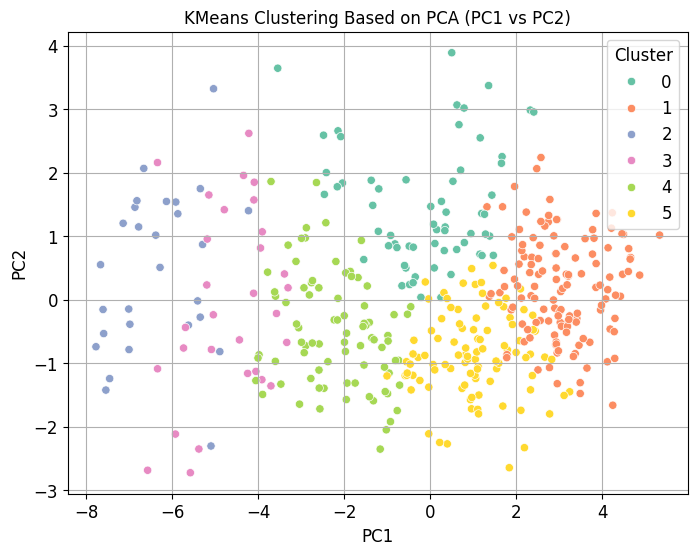

In [81]:
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca_rho[:, 0], y=X_pca_rho[:, 1], hue=cluster_labels, palette='Set2')
plt.title("KMeans Clustering Based on PCA (PC1 vs PC2)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.legend(title='Cluster')
plt.show()

In [82]:
rho_result = pd.DataFrame({
    'NLC': X_rho.index,
    'cluster_rho': cluster_labels
})
print(rho_result.head())

    NLC  cluster_rho
0   750            0
1  1404            0
2  3000            5
3   500            5
4   502            4


In [83]:
from sklearn.metrics import silhouette_score
score = silhouette_score(X_cluster_0, cluster_labels)
print(f"Silhouette score: {score:.3f}")

Silhouette score: 0.181


In [84]:
# 如果已有 cluster_rho，先删除
stations['NLC'] = stations['NLC'].astype(str)
rho_result['NLC'] = rho_result['NLC'].astype(str)
if 'cluster_rho' in stations_rho.columns:
    stations_rho = stations_rho.drop(columns=['cluster_rho'])

# 然后再进行合并
stations_rho = stations_rho.merge(rho_result, on='NLC', how='left')
stations_rho['cluster_rho'] = stations_rho['cluster_rho'].fillna(-1).astype(int)

In [ ]:
stations_rho.to_file("data/stations_rho.geojson", driver="GeoJSON")

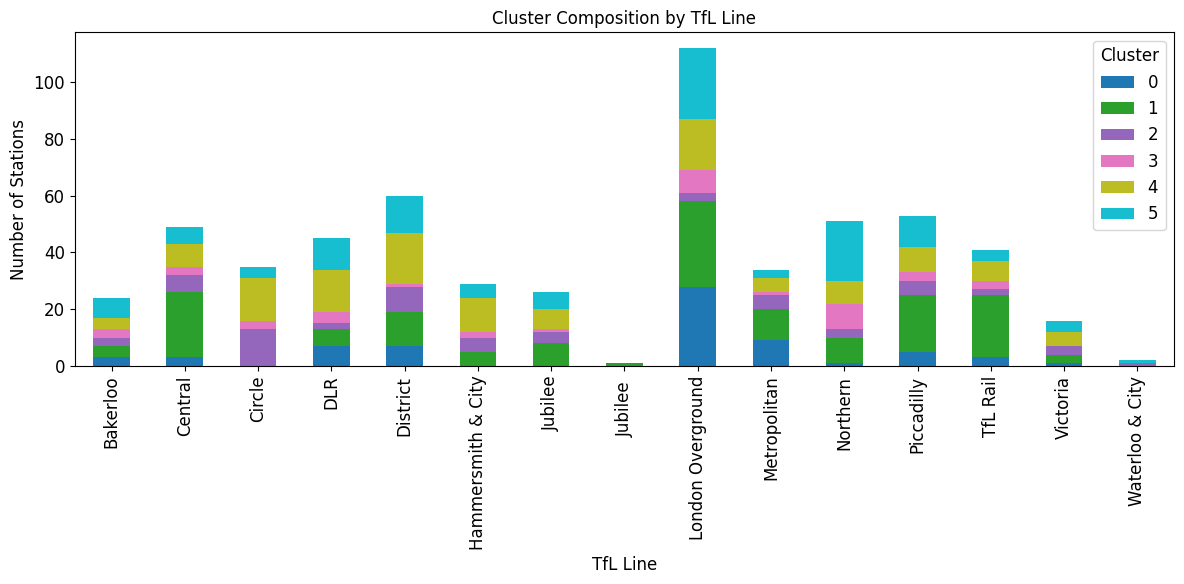

In [87]:
stations_exploded = stations_rho.copy()

# 拆分 LINES 列，并展开为多行
stations_exploded['LINE'] = stations_exploded['LINES'].str.split(', ')
stations_exploded = stations_exploded.explode('LINE')
line_cluster_counts = (
    stations_exploded
    .groupby(['LINE', 'cluster_rho'])
    .size()
    .unstack(fill_value=0)
    .sort_index()
)
import matplotlib.pyplot as plt

line_cluster_counts.plot(
    kind='bar',
    stacked=True,
    figsize=(12, 6),
    colormap='tab10'
)
plt.ylabel("Number of Stations")
plt.xlabel("TfL Line")
plt.title("Cluster Composition by TfL Line")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()

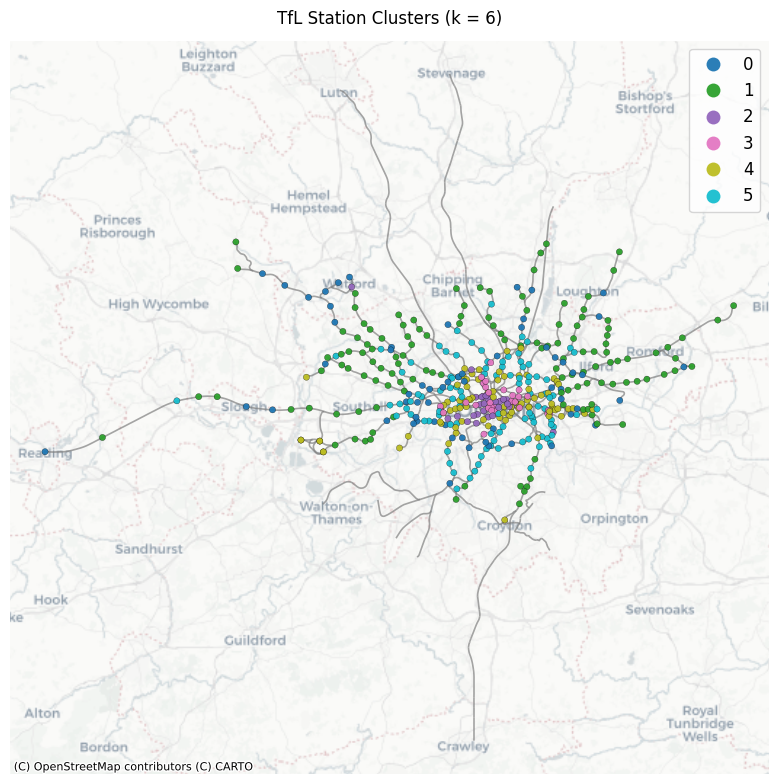

In [88]:
# 投影到 Web Mercator（如果还没做）
stations_cluster_webmerc = stations_rho.to_crs(epsg=3857)
lines_webmerc = lines.to_crs(epsg=3857)

# 设置绘图参数
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 12

# 创建 figure & ax
fig, ax = plt.subplots(figsize=(12, 8))

# 使用分类配色（tab10 支持最多10类）
lines_webmerc.plot(
    ax=ax,
    linewidth=1.2,
    color='gray',
    alpha=0.7,
    zorder=1  # 确保在站点图层下方
)
stations_cluster_webmerc.plot(
    column='cluster_rho',
    cmap='tab10',  # 分类色彩
    categorical=True,
    legend=True,
    ax=ax,
    markersize=20,
    alpha=0.95,
    edgecolor='black',
    linewidth=0.2
)

# 添加灰色 OSM 底图
ctx.add_basemap(ax, 
    source=ctx.providers.CartoDB.Positron,
    crs=stations_cluster_webmerc.crs
)

# 去掉坐标轴
ax.set_axis_off()

# 添加标题
ax.set_title("TfL Station Clusters (k = 6)", pad=12)

plt.tight_layout()
plt.show()

In [89]:
# 确保 NLC 都是字符串格式
analyse_df['NLC'] = analyse_df['NLC'].astype(str)
rho_result['NLC'] = rho_result['NLC'].astype(str)


# 合并到原始分析表中
analyse_rho = analyse_df.merge(rho_result, on='NLC', how='left')

# 可选：填补未聚类的站点
analyse_rho['cluster_rho'] = analyse_rho['cluster_rho'].fillna(-1).astype(int)


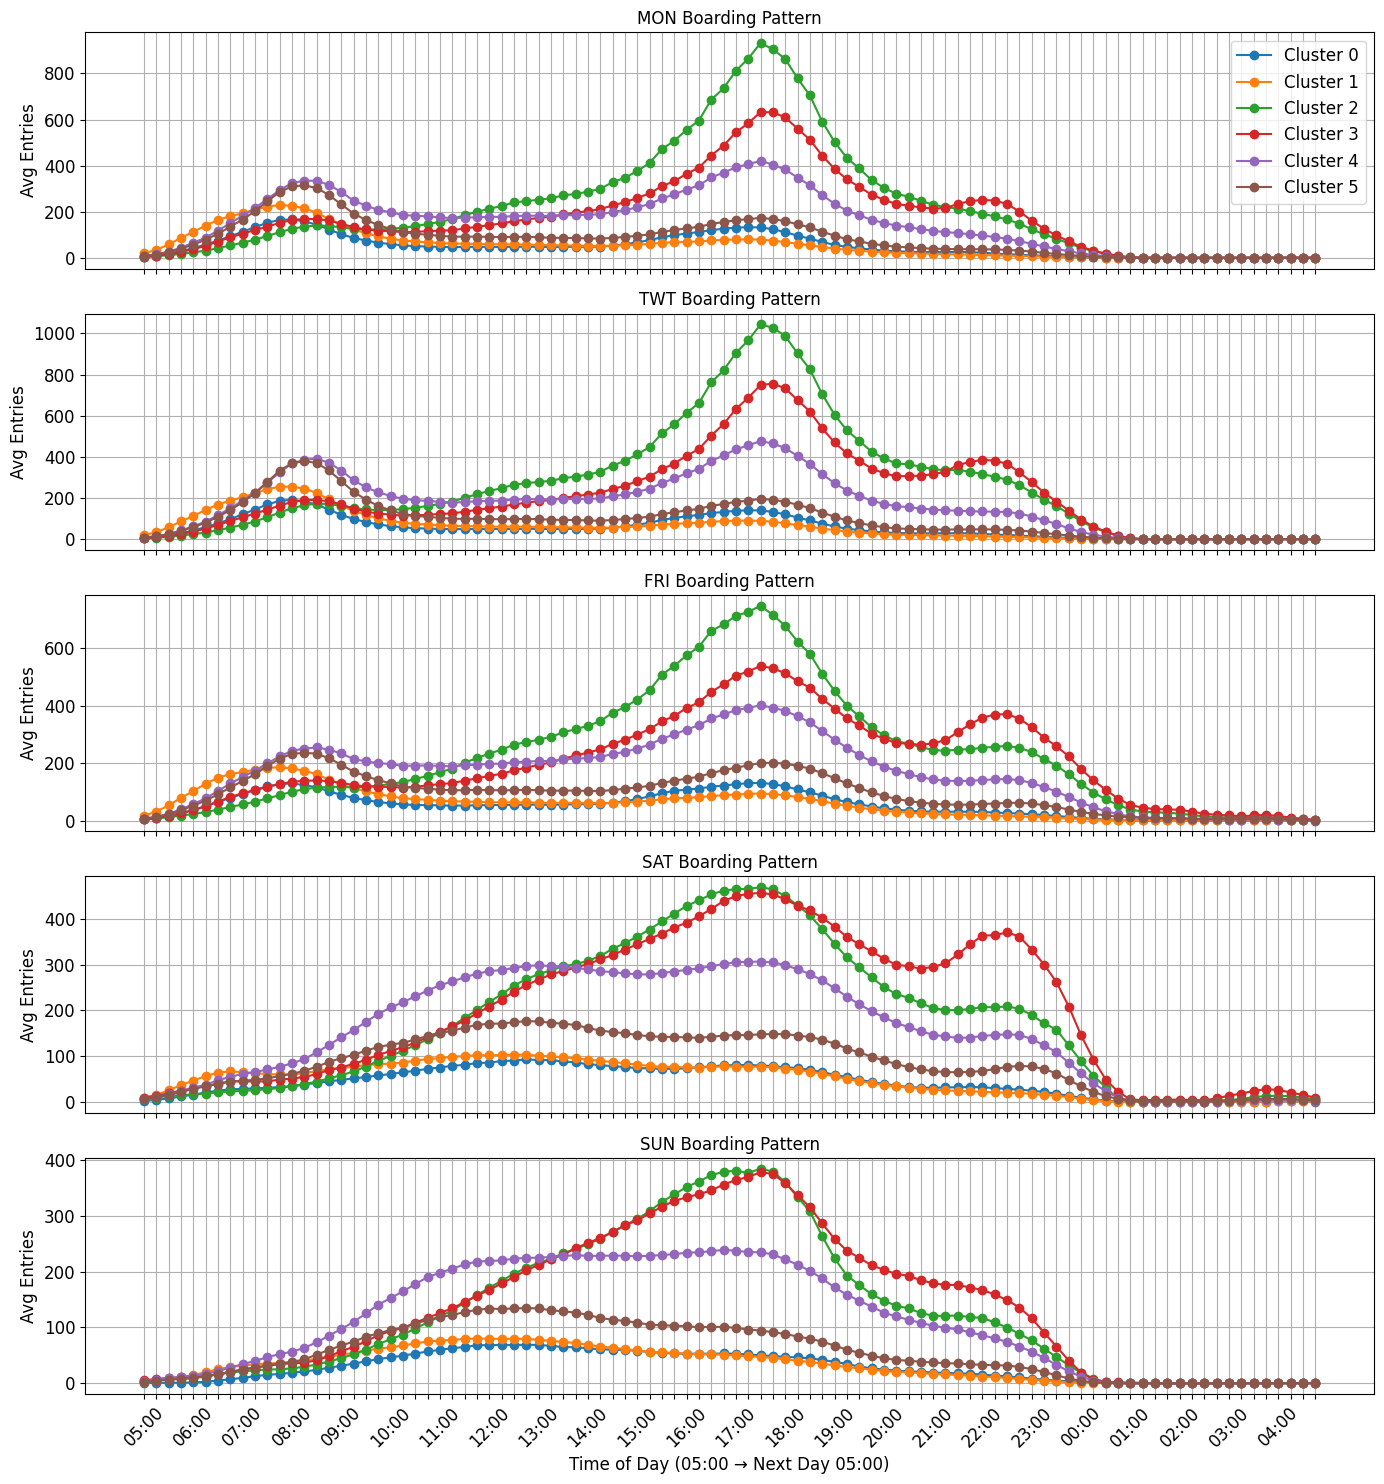

In [90]:
days = ['mon', 'twt', 'fri', 'sat', 'sun']
n_days = len(days)

fig, axes = plt.subplots(n_days, 1, figsize=(14, 3 * n_days), sharex=True)

for i, day in enumerate(days):
    # 提取该天的 entries 列
    entry_cols = [col for col in analyse_rho.columns if f'entries' in col and f'{day}' in col]

    # 构建曲线
    entry_curves = (
        analyse_rho
        .groupby('cluster_rho')[entry_cols]
        .mean()
    )

    # 按 quarter_map 顺序排序
    sorted_cols = sorted(entry_curves.columns, key=lambda x: quarter_map.get(x.replace(f'_{day}_entries', ''), 999))
    entry_curves = entry_curves[sorted_cols]

    # 绘图：x 坐标用 0~95，y 为对应值
    ax = axes[i]
    x = list(range(len(entry_curves.columns)))  # [0, 1, ..., 95]
    for cluster_id, row in entry_curves.iterrows():
        ax.plot(x, row.values, label=f'Cluster {cluster_id}', marker='o')

    # 设置 xtick 每小时显示一次
    xticks = list(range(len(entry_curves.columns)))  # x 是 0 到 95
    xticklabels = []
    for col in entry_curves.columns:
        time_str = col.split('_')[0]  # "0615-0630"
        hour = int(time_str[:2])
        minute = int(time_str[2:4])
        if minute == 0:
            xticklabels.append(f"{hour:02d}:00")
        else:
            xticklabels.append("")

    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels, rotation=45)

    ax.set_title(f"{day.upper()} Boarding Pattern")
    ax.set_ylabel("Avg Entries")
    ax.grid(True)
    if i == n_days - 1:
        ax.set_xlabel("Time of Day (05:00 → Next Day 05:00)")
    if i == 0:
        ax.legend(loc='upper right')

plt.tight_layout()
plt.show()

两者的对比

In [91]:
compare_result = rho_result.merge(ratio_result, on='NLC')
labels_rho = compare_result['cluster_rho']
labels_pca = compare_result['cluster_ratio']

In [92]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
ari = adjusted_rand_score(labels_rho, labels_pca)
nmi = normalized_mutual_info_score(labels_rho, labels_pca)

print(f"Adjusted Rand Index (ARI): {ari:.3f}")
print(f"Normalized Mutual Information (NMI): {nmi:.3f}")

Adjusted Rand Index (ARI): 0.581
Normalized Mutual Information (NMI): 0.618
